In [52]:
import os
import pandas as pd
import xgboost as xgb
import numpy as np
import statsmodels as sm
from statsmodels.genmod.generalized_linear_model import GLM
from sklearn.preprocessing import OneHotEncoder
import tweedie
import seaborn as sn
import matplotlib.pyplot as plt
import warnings
#warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import pygraphviz
#warnings.filterwarnings(action='ignore', category=UserWarning)
from xgboost import plot_tree
from sklearn.utils import class_weight
import optuna
from optuna.trial import TrialState


In [53]:

class train_validate_n_test(object):

    def __init__(self) -> None:    
        dataset_filename = "xgboost_feat_train_ds_all_stns.csv"
        full_set = pd.read_csv(dataset_filename,parse_dates=['dt_ts'])
        full_set = full_set.drop(['Unnamed: 0'],axis=1)

        self.train_stop_time_fold_1 = '2021/11/30 00:00'
        self.val_stop_time_fold_1 = '2021/12/05 00:00'
        self.train_stop_time_fold_2 = self.val_stop_time_fold_1
        self.val_stop_time_fold_2 = '2021/12/10 00:00'
        self.train_stop_time_fold_3 = self.val_stop_time_fold_2
        self.val_stop_time_fold_3 = '2021/12/16 00:00'

        #self.classes_weights = self.analyze_target(full_set)
        self.full_set = self.onehotencode_cat_var(full_set)


    def analyze_target(self,full_set):
        print('###################################### TARGET data EXPLORATION ###########################################')
        print('Target class frequency:')
        print(full_set['target'].value_counts())

        full_set['target'].hist()
        plt.title('Target histogram')
        plt.xlabel('demand value (class)')
        plt.ylabel('count')
        plt.show()

        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=full_set['target'])
        print('\nTarget class weights:')
        print(np.unique(classes_weights))
        print('##########################################################################################################')
        return classes_weights


    def onehotencode_cat_var(self,full_set):
        full_set = full_set.astype({"stn_id":str,"block_id":str,"ts_of_day":str,"hr_of_day":str,"day_of_wk":str,"day_of_mn":str,"wk_of_mon":str })
        full_set = pd.get_dummies(full_set, prefix_sep="_",columns =["stn_id","block_id","ts_of_day","hr_of_day","day_of_wk","day_of_mn","wk_of_mon"],drop_first=True)
        #ds_df = ds_df.drop('rem_blk_outf_'+self.stn,axis=1)
        return full_set


    def walk_forward_val_n_train_set(self,fold):
        # split validation set into 3 parts
        if (fold==1):
            train1 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_1]
            tr1 = train1.drop(["target","dt_ts"], axis=1)
            label_train1 = pd.DataFrame(train1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train1)
            dtrain1 = xgb.DMatrix(tr1, label=label_train1,weight=classes_weights)

            print('\n',train1.isnull().values.any(),'\n')

            val1 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_1) & (self.full_set['dt_ts'] < self.val_stop_time_fold_1)]
            v1 = val1.drop(["target","dt_ts"], axis=1)
            label_val1 = pd.DataFrame(val1["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val1)
            dval1 = xgb.DMatrix(v1, label=label_val1,weight=classes_weights)
            print('\n',val1.isnull().values.any(),'\n')

            return dtrain1, dval1
        
        elif (fold==2):
            train2 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_2]
            tr2 = train2.drop(["target","dt_ts"], axis=1)
            label_train2 = pd.DataFrame(train2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train2)
            dtrain2 = xgb.DMatrix(tr2, label=label_train2,weight=classes_weights)

            print('\n',train2.isnull().values.any(),'\n')

            val2 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_2) & (self.full_set['dt_ts'] < self.val_stop_time_fold_2)]
            v2 = val2.drop(["target","dt_ts"], axis=1)
            label_val2 = pd.DataFrame(val2["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val2)
            dval2 = xgb.DMatrix(v2, label=label_val2,weight=classes_weights)

            print('\n',val2.isnull().values.any(),'\n')

            return dtrain2,dval2
        
        else:
            train3 = self.full_set.loc[self.full_set['dt_ts'] < self.train_stop_time_fold_3]
            tr3 = train3.drop(["target","dt_ts"], axis=1)
            label_train3 = pd.DataFrame(train3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train3)
            dtrain3 = xgb.DMatrix(tr3, label=label_train3,weight=classes_weights)

            print('\n',train3.isnull().values.any(),'\n')

            val3 = self.full_set.loc[(self.full_set['dt_ts'] >= self.train_stop_time_fold_3) & (self.full_set['dt_ts'] < self.val_stop_time_fold_3)]
            v3 = val3.drop(["target","dt_ts"], axis=1)
            label_val3 = pd.DataFrame(val3["target"])
            classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_val3)
            dval3 = xgb.DMatrix(v3, label=label_val3,weight=classes_weights)

            print('\n',val3.isnull().values.any(),'\n')

            return dtrain3,dval3



    def xgb_train_validate(self,params,num_round, e_s_r,t_v_p):
        dtrain1, dval1 = self.walk_forward_val_n_train_set(fold=1)
        watchlist1  = [(dtrain1,'train1_tweedie_loss'), (dval1, 'val1_tweedie_loss')]
        evals_result1 = {}
        model1 = xgb.train(params=params, dtrain=dtrain1, num_boost_round=num_round, evals=watchlist1, evals_result=evals_result1,  early_stopping_rounds=e_s_r,verbose_eval=False)
        val1_error = evals_result1['val1_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain2, dval2 = self.walk_forward_val_n_train_set(fold=2)
        watchlist2  = [(dtrain2,'train2_tweedie_loss'), (dval2, 'val2_tweedie_loss')]
        evals_result2 = {}
        model2 = xgb.train(params=params, dtrain=dtrain2, num_boost_round=num_round, evals=watchlist2, evals_result=evals_result2, early_stopping_rounds=e_s_r,xgb_model=model1,verbose_eval=False )
        val2_error = evals_result2['val2_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        dtrain3, dval3 = self.walk_forward_val_n_train_set(fold=3)
        watchlist3  = [(dtrain3,'train3_tweedie_loss'), (dval3, 'val3_tweedie_loss')]
        evals_result3 = {}
        self.model3 = xgb.train(params=params, dtrain=dtrain3, num_boost_round=num_round, evals=watchlist3, evals_result=evals_result3, early_stopping_rounds=e_s_r,xgb_model=model2,verbose_eval=False )
        val3_error = evals_result3['val3_tweedie_loss']['tweedie-nloglik@'+str(t_v_p)]

        print('\n')
        print('###################################### VALIDATION Loss ###########################################')
        print('Last estimator val1_error',val1_error[-1]) # Result is a list of validation loss from each of boosters/estimators, last one is final val loss.
        print('Last estimator val2_error',val2_error[-1])
        print('Last estimator val3_error',val3_error[-1])

        val_avg_error = np.mean(np.array([val1_error[-1],val2_error[-1],val3_error[-1]]))
        print('val_avg_error',val_avg_error)
        print('##################################################################################################')
        return val_avg_error


    def display_tweedie_plot(self,):
        tvs = tweedie.tweedie(mu=1, p=1.1, phi=1.5).rvs(6000)
        sn.set(rc={'figure.figsize':(10,5)})
        # plt.figure(figsize=(25,10))
        sn.displot(tvs)
        plt.title('Parametric tweedie distribution')
        plt.xlabel('demand value (class)')
        plt.show()
        return


    def evaluate_predictions(self,model):
        test = self.full_set.loc[self.full_set['dt_ts'] >= self.val_stop_time_fold_3]
        X_test = test.drop(["target","dt_ts"], axis=1)
        label_test = pd.DataFrame(test["target"])
        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_test)
        dtest = xgb.DMatrix(X_test, label=label_test,weight=classes_weights)

        print('\n',test.isnull().values.any(),'\n')

        preds = model.predict(dtest)
        preds = np.rint(preds)
        label_test = label_test['target'].to_numpy()

        print('####################################### PREDICTION #################################################')    
        plt.plot(preds,'*')
        plt.ylabel('Demand value (prediction)')
        plt.xlabel('Time')     
        plt.show()
        plt.plot(label_test,'*')
        plt.ylabel('Demand value (Ground-truth)')
        plt.xlabel('Time')     
        plt.show()
        # plt.plot(label_test[40:60],'*')
        # plt.title('zoomed true label test')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()
        # plt.plot(preds[40:60],'*')
        # plt.title('zoomed pred label')
        # plt.ylabel('Demand value')
        # plt.xlabel('Time')     
        # plt.show()

        #"use confusion matrix, ROC, F1 scores to evaluate"
        cm = confusion_matrix(label_test,preds)
        max_classes = max(len(np.unique(label_test)),len(np.unique(preds)))
        df_cm = pd.DataFrame(cm, index = [i for i in range(max_classes)],
                        columns = [i for i in range(max_classes)])
        plt.figure(figsize = (10,7))      
        s = sn.heatmap(df_cm, annot=True, )
        s.set(xlabel='Predicted-Label', ylabel='True-Label')
        print('##################################################################################################')

        return X_test,label_test, preds


    def identify_tweedie_variance_param():
        #TODO:#"fit on data"
        # follow this tutorial https://notebook.community/thequackdaddy/tweedie/example/tweedie_demo
        # GLM.estimate_tweedie_power()
        # #Training model
        # tweedie_model = sm.GLM(y_train, X_train, exposure = df_train.exposure, family=sm.families.Tweedie(link=None,var_power=1.5,eql=True))
        # tweedie_result = tweedie_model.fit()
        # #Using the initial model output to decide the optimum index parameter "p"
        # GLM.estimate_tweedie_power(training_result, method='brentq', low=1.01, high=5.0)
        # tweedie_model.estimate_tweedie_power(tweedie_result.mu, method='brentq', low=1.01, high=5.0)
        return


    def make_predictions(self,best_params,num_round, e_s_r):
        #TODO:#for new predictions after tuning model
        train4 = self.full_set.loc[self.full_set['dt_ts'] < self.val_stop_time_fold_3]
        tr4 = train4.drop(["target","dt_ts"], axis=1)
        label_train4 = pd.DataFrame(train4["target"])
        classes_weights = class_weight.compute_sample_weight(class_weight='balanced',y=label_train4)
        dtrain4 = xgb.DMatrix(tr4, label=label_train4,weight=classes_weights)

        watchlist4  = [(dtrain4,'train3_tweedie_loss')]
        evals_result4 = {}
        self.model4 = xgb.train(params=best_params, dtrain=dtrain4, num_boost_round=num_round, evals=watchlist4, evals_result=evals_result4, early_stopping_rounds=e_s_r,verbose_eval=False )
        return self.model4 # best_model
    

    def visualize_tree(self,):
        #TODO:#"draw out a few trees to interpret results"        
        #xgb.plot_tree(self.train3)
        plot_tree(self.model3)

        return



In [54]:

def objective(trial):

    os.chdir("c:\Work\WORK_PACKAGE\Demand_forecasting\BLUESG_Demand_data\Data-preprocessing_data_generation")
    t_v_t = train_validate_n_test()

    tweedie_variance_power = round(trial.suggest_float(name='tweedie_variance_power',low=1.1,high=1.9,step=0.1,log=False),1)

    ######  SET Hyperparameter's range for tuning ######
    early_stopping_rounds = 30
    eval_metric = 'tweedie-nloglik@'+str(tweedie_variance_power)
    num_round= 1000
    # Hyperparameters and algorithm parameters are described here
    params = {"max_depth": trial.suggest_int('max_depth', 3, 10),
            "eta": trial.suggest_float(name='learning_rate', low=0.0001, high=0.1,log=True),
            "subsample" : round(trial.suggest_float(name='subsample', low=0.1, high=1.0,step=0.1),1),
            "colsample_bytree": round(trial.suggest_float(name='colsample_bytree', low=0.1, high=1.0,step=0.1),1),
            'eval_metric':eval_metric, ## try using AUC as well.. 
            'tweedie_variance_power': tweedie_variance_power,
            'gamma': trial.suggest_int('gamma', 0, 5),
            'reg_alpha': trial.suggest_int('reg_alpha', 0, 5), 
            'reg_lambda': trial.suggest_int('reg_lambda', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            "objective": 'reg:tweedie',
            }
    ######  SET Hyperparameter's range for tuning ######

    val_avg_error = t_v_t.xgb_train_validate(params,num_round, early_stopping_rounds,tweedie_variance_power)
    return val_avg_error

In [55]:

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, timeout=12000, n_trials=500)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

    #print("Best hyperparameters:", study.best_params)

    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig.show()

    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    fig = optuna.visualization.plot_slice(study)
    fig.show()

    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
    best_params = {"max_depth": study.best_params["max_depth"],
            "eta": study.best_params["eta"],
            "subsample" : study.best_params["subsample"],
            "colsample_bytree": study.best_params["colsample_bytree"],
            'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
            'tweedie_variance_power': best_tweedie_variance_power,
            'gamma': study.best_params["gamma"],
            'reg_alpha': study.best_params["reg_alpha"], 
            'reg_lambda': study.best_params["reg_lambda"],
            'min_child_weight': study.best_params["min_child_weight"],
            "objective": 'reg:tweedie',
            }
    early_stopping_rounds = 30
    eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
    num_round= 1000

    t_v_t = train_validate_n_test()
    best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
    t_v_t.evaluate_predictions(best_model)

    # t_v_t.display_tweedie_plot() # compare the graphs from target histogram and this function to choose tweedie_variance_power 
    # X_test,label_test, preds = t_v_t.evaluate_predictions()
    # t_v_t.visualize_tree()
    # # print('\n',"tweedie_variance_power ",tweedie_variance_power,'\n')

[I 2023-04-13 13:23:45,738] A new study created in memory with name: no-name-7f663655-4d85-4997-9879-49209cd3b071



 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:25:00,585] Trial 0 finished with value: 4.698616666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'learning_rate': 0.0003764051051512748, 'subsample': 0.8, 'colsample_bytree': 0.2, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 4, 'min_child_weight': 7}. Best is trial 0 with value: 4.698616666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.256751
Last estimator val2_error 4.028064
Last estimator val3_error 4.811035
val_avg_error 4.698616666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:26:34,435] Trial 1 finished with value: 4.529419666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 10, 'learning_rate': 0.0029997196032076137, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 2}. Best is trial 1 with value: 4.529419666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.844291
Last estimator val2_error 4.017507
Last estimator val3_error 4.726461
val_avg_error 4.529419666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:26:43,421] Trial 2 finished with value: 4.484123 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 5, 'learning_rate': 0.0638647589382723, 'subsample': 0.4, 'colsample_bytree': 0.8, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 5}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.867233
Last estimator val2_error 3.725765
Last estimator val3_error 4.859371
val_avg_error 4.484123
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:28:42,325] Trial 3 finished with value: 4.891925333333333 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 5, 'learning_rate': 0.00032895752021031656, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 3, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 2}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.572202
Last estimator val2_error 3.964798
Last estimator val3_error 5.138776
val_avg_error 4.891925333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:28:50,894] Trial 4 finished with value: 5.629361 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 3, 'learning_rate': 0.035019518937087324, 'subsample': 1.0, 'colsample_bytree': 0.9, 'gamma': 4, 'reg_alpha': 1, 'reg_lambda': 4, 'min_child_weight': 4}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.85441
Last estimator val2_error 5.176646
Last estimator val3_error 5.857027
val_avg_error 5.629361
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:30:24,908] Trial 5 finished with value: 4.907066333333333 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 6, 'learning_rate': 0.0003226905525937058, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 6}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.583934
Last estimator val2_error 3.985194
Last estimator val3_error 5.152071
val_avg_error 4.907066333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:31:27,565] Trial 6 finished with value: 8.142830333333334 and parameters: {'tweedie_variance_power': 1.2000000000000002, 'max_depth': 4, 'learning_rate': 0.00010171357189346834, 'subsample': 0.1, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 9.184613
Last estimator val2_error 6.303529
Last estimator val3_error 8.940349
val_avg_error 8.142830333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:32:56,607] Trial 7 finished with value: 4.675372 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 9, 'learning_rate': 0.0003075154861678151, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 0, 'min_child_weight': 6}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.280854
Last estimator val2_error 3.88917
Last estimator val3_error 4.856092
val_avg_error 4.675372
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:34:33,383] Trial 8 finished with value: 5.686279 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 9, 'learning_rate': 0.0029352688650674187, 'subsample': 0.8, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.989248
Last estimator val2_error 5.165251
Last estimator val3_error 5.904338
val_avg_error 5.686279
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:34:47,941] Trial 9 finished with value: 4.596403666666666 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 10, 'learning_rate': 0.03817135483072482, 'subsample': 1.0, 'colsample_bytree': 0.2, 'gamma': 1, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 9}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.883074
Last estimator val2_error 4.033298
Last estimator val3_error 4.872839
val_avg_error 4.596403666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:34:56,497] Trial 10 finished with value: 14.083874999999999 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 7, 'learning_rate': 0.07834928219646153, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 15.610437
Last estimator val2_error 10.796185
Last estimator val3_error 15.845003
val_avg_error 14.083874999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:35:51,366] Trial 11 finished with value: 9.718005 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 6, 'learning_rate': 0.005063210969634764, 'subsample': 0.6, 'colsample_bytree': 0.4, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 1}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 10.078862
Last estimator val2_error 9.082239
Last estimator val3_error 9.992914
val_avg_error 9.718005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:36:22,297] Trial 12 finished with value: 5.390986333333333 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 5, 'learning_rate': 0.0070078369005192225, 'subsample': 0.5, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 4}. Best is trial 2 with value: 4.484123.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.918481
Last estimator val2_error 4.364853
Last estimator val3_error 5.889625
val_avg_error 5.390986333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:37:49,477] Trial 13 finished with value: 4.162259333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'learning_rate': 0.0019530229590260513, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'gamma': 3, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 13 with value: 4.162259333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.529297
Last estimator val2_error 3.576457
Last estimator val3_error 4.381024
val_avg_error 4.162259333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:39:25,727] Trial 14 finished with value: 4.250552666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 7, 'learning_rate': 0.0012253296611240908, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'gamma': 3, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 4}. Best is trial 13 with value: 4.162259333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.724524
Last estimator val2_error 3.541862
Last estimator val3_error 4.485272
val_avg_error 4.250552666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:40:55,808] Trial 15 finished with value: 4.246308 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'learning_rate': 0.0013409373655209262, 'subsample': 0.2, 'colsample_bytree': 0.7000000000000001, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 13 with value: 4.162259333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.694236
Last estimator val2_error 3.621891
Last estimator val3_error 4.422797
val_avg_error 4.246308
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:42:28,041] Trial 16 finished with value: 4.375980333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'learning_rate': 0.0010915602940096097, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'gamma': 0, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 13 with value: 4.162259333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.889807
Last estimator val2_error 3.701719
Last estimator val3_error 4.536415
val_avg_error 4.375980333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:43:06,270] Trial 17 finished with value: 4.111476333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'learning_rate': 0.01032329306020988, 'subsample': 0.2, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 2, 'min_child_weight': 1}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.38262
Last estimator val2_error 3.568338
Last estimator val3_error 4.383471
val_avg_error 4.111476333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:44:01,859] Trial 18 finished with value: 4.507167666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 8, 'learning_rate': 0.011680945417141216, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 2, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.768927
Last estimator val2_error 3.997513
Last estimator val3_error 4.755063
val_avg_error 4.507167666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:44:30,108] Trial 19 finished with value: 10.235527666666668 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 9, 'learning_rate': 0.017470180885870382, 'subsample': 0.2, 'colsample_bytree': 0.9, 'gamma': 3, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 1}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 10.152803
Last estimator val2_error 9.418126
Last estimator val3_error 11.135654
val_avg_error 10.235527666666668
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:45:09,462] Trial 20 finished with value: 4.1687639999999995 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 6, 'learning_rate': 0.015545499404452186, 'subsample': 0.6, 'colsample_bytree': 0.1, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.529408
Last estimator val2_error 3.516478
Last estimator val3_error 4.460406
val_avg_error 4.1687639999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:45:35,472] Trial 21 finished with value: 4.129764000000001 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 6, 'learning_rate': 0.01252090568150884, 'subsample': 0.6, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.450699
Last estimator val2_error 3.48568
Last estimator val3_error 4.452913
val_avg_error 4.129764000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:46:13,709] Trial 22 finished with value: 4.122221 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'learning_rate': 0.009043346780855626, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.393692
Last estimator val2_error 3.552795
Last estimator val3_error 4.420176
val_avg_error 4.122221
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:47:07,938] Trial 23 finished with value: 4.165924333333334 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'learning_rate': 0.007043702942279315, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 3, 'min_child_weight': 2}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.49276
Last estimator val2_error 3.487995
Last estimator val3_error 4.517018
val_avg_error 4.165924333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:47:24,753] Trial 24 finished with value: 5.405981999999999 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 6, 'learning_rate': 0.025217390631609646, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.4, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 1}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.931323
Last estimator val2_error 4.361376
Last estimator val3_error 5.925247
val_avg_error 5.405981999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:48:06,129] Trial 25 finished with value: 4.517424 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 7, 'learning_rate': 0.010150865465660828, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.5, 'gamma': 0, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.761788
Last estimator val2_error 3.986868
Last estimator val3_error 4.803616
val_avg_error 4.517424
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:48:52,018] Trial 26 finished with value: 5.687100333333333 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 4, 'learning_rate': 0.0056834605692157505, 'subsample': 0.4, 'colsample_bytree': 0.30000000000000004, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 3, 'min_child_weight': 10}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.959388
Last estimator val2_error 5.192462
Last estimator val3_error 5.909451
val_avg_error 5.687100333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:49:16,053] Trial 27 finished with value: 4.143971 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'learning_rate': 0.022934397220475782, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.42101
Last estimator val2_error 3.552509
Last estimator val3_error 4.458394
val_avg_error 4.143971
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:50:40,227] Trial 28 finished with value: 5.4569806666666665 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 9, 'learning_rate': 0.004238050147204214, 'subsample': 0.5, 'colsample_bytree': 0.30000000000000004, 'gamma': 2, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 1}. Best is trial 17 with value: 4.111476333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 6.012601
Last estimator val2_error 4.375093
Last estimator val3_error 5.983248
val_avg_error 5.4569806666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:51:15,761] Trial 29 finished with value: 4.098597333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.009678005622041122, 'subsample': 0.8, 'colsample_bytree': 0.4, 'gamma': 1, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.378271
Last estimator val2_error 3.555166
Last estimator val3_error 4.362355
val_avg_error 4.098597333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:52:15,746] Trial 30 finished with value: 4.484554666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0006587327041809475, 'subsample': 0.8, 'colsample_bytree': 0.2, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.000572
Last estimator val2_error 3.893059
Last estimator val3_error 4.560033
val_avg_error 4.484554666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:53:03,847] Trial 31 finished with value: 4.1022 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.008420418970087806, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.4, 'gamma': 0, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.382103
Last estimator val2_error 3.556976
Last estimator val3_error 4.367521
val_avg_error 4.1022
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:53:46,851] Trial 32 finished with value: 4.479205 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.008436399151458463, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 1, 'reg_alpha': 1, 'reg_lambda': 0, 'min_child_weight': 8}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.730598
Last estimator val2_error 3.98979
Last estimator val3_error 4.717227
val_avg_error 4.479205
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:54:50,896] Trial 33 finished with value: 4.552414 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 3, 'learning_rate': 0.0027016951320968235, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.87209
Last estimator val2_error 4.078947
Last estimator val3_error 4.706205
val_avg_error 4.552414
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:55:03,798] Trial 34 finished with value: 4.099261 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.04129353967960751, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.4, 'gamma': 2, 'reg_alpha': 2, 'reg_lambda': 1, 'min_child_weight': 8}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.392412
Last estimator val2_error 3.562641
Last estimator val3_error 4.34273
val_avg_error 4.099261
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:55:14,391] Trial 35 finished with value: 4.493991 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 5, 'learning_rate': 0.04556199139714894, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 2, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 8}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.886755
Last estimator val2_error 3.71923
Last estimator val3_error 4.875988
val_avg_error 4.493991
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:55:38,284] Trial 36 finished with value: 4.137225666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05074243697307494, 'subsample': 0.8, 'colsample_bytree': 0.1, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 0, 'min_child_weight': 8}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.477857
Last estimator val2_error 3.56127
Last estimator val3_error 4.37255
val_avg_error 4.137225666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:55:45,297] Trial 37 finished with value: 5.708537 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 5, 'learning_rate': 0.09407789215171077, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2, 'gamma': 1, 'reg_alpha': 0, 'reg_lambda': 1, 'min_child_weight': 6}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.977521
Last estimator val2_error 5.198244
Last estimator val3_error 5.949846
val_avg_error 5.708537
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:56:03,591] Trial 38 finished with value: 4.113708333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.023943690062883327, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.440781
Last estimator val2_error 3.488718
Last estimator val3_error 4.411626
val_avg_error 4.113708333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:56:17,077] Trial 39 finished with value: 4.480361333333334 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.027660923887037128, 'subsample': 0.5, 'colsample_bytree': 0.4, 'gamma': 3, 'reg_alpha': 1, 'reg_lambda': 1, 'min_child_weight': 9}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.867542
Last estimator val2_error 3.729569
Last estimator val3_error 4.843973
val_avg_error 4.480361333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:56:41,853] Trial 40 finished with value: 4.475141666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.016594918673890836, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 2, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 6}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.725262
Last estimator val2_error 3.988587
Last estimator val3_error 4.711576
val_avg_error 4.475141666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:56:57,036] Trial 41 finished with value: 4.490892333333334 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 4, 'learning_rate': 0.030507254283361433, 'subsample': 0.8, 'colsample_bytree': 0.30000000000000004, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 7}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.895501
Last estimator val2_error 3.72368
Last estimator val3_error 4.853496
val_avg_error 4.490892333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:57:08,056] Trial 42 finished with value: 4.134535333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 5, 'learning_rate': 0.05672022334441835, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.30000000000000004, 'gamma': 1, 'reg_alpha': 2, 'reg_lambda': 0, 'min_child_weight': 8}. Best is trial 29 with value: 4.098597333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.460544
Last estimator val2_error 3.486426
Last estimator val3_error 4.456636
val_avg_error 4.134535333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:57:25,942] Trial 43 finished with value: 4.096131333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.019490962045155873, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 2, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 7}. Best is trial 43 with value: 4.096131333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.412949
Last estimator val2_error 3.489478
Last estimator val3_error 4.385967
val_avg_error 4.096131333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:57:54,361] Trial 44 finished with value: 4.071516333333332 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.017648866162048905, 'subsample': 0.9, 'colsample_bytree': 0.4, 'gamma': 2, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 6}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333742
Last estimator val2_error 3.56301
Last estimator val3_error 4.317797
val_avg_error 4.071516333333332
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:58:12,490] Trial 45 finished with value: 4.0907116666666665 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.018037278499449385, 'subsample': 1.0, 'colsample_bytree': 0.4, 'gamma': 3, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.38935
Last estimator val2_error 3.49809
Last estimator val3_error 4.384695
val_avg_error 4.0907116666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:58:21,562] Trial 46 finished with value: 4.476628 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.06948433655480885, 'subsample': 1.0, 'colsample_bytree': 0.4, 'gamma': 3, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.861413
Last estimator val2_error 3.728234
Last estimator val3_error 4.840237
val_avg_error 4.476628
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:58:38,809] Trial 47 finished with value: 4.092084666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.03474067151748575, 'subsample': 0.9, 'colsample_bytree': 0.5, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.398463
Last estimator val2_error 3.494645
Last estimator val3_error 4.383146
val_avg_error 4.092084666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:59:02,476] Trial 48 finished with value: 4.089996999999999 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.019818143148232385, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.391306
Last estimator val2_error 3.496412
Last estimator val3_error 4.382273
val_avg_error 4.089996999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 13:59:23,145] Trial 49 finished with value: 4.088994666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.017594889304134765, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.389794
Last estimator val2_error 3.499982
Last estimator val3_error 4.377208
val_avg_error 4.088994666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:00:11,130] Trial 50 finished with value: 5.142186 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.00012880494687873825, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.814311
Last estimator val2_error 4.166101
Last estimator val3_error 5.446146
val_avg_error 5.142186
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:00:41,909] Trial 51 finished with value: 4.088658 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.01600564980142287, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.389319
Last estimator val2_error 3.497811
Last estimator val3_error 4.378844
val_avg_error 4.088658
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:00:59,944] Trial 52 finished with value: 4.089912333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.03451170758534077, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.391017
Last estimator val2_error 3.497563
Last estimator val3_error 4.381157
val_avg_error 4.089912333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:01:34,153] Trial 53 finished with value: 4.469779333333334 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.012855567294298247, 'subsample': 1.0, 'colsample_bytree': 0.6, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.845208
Last estimator val2_error 3.732021
Last estimator val3_error 4.832109
val_avg_error 4.469779333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:01:54,930] Trial 54 finished with value: 4.089976333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.020016102946287705, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.393358
Last estimator val2_error 3.49564
Last estimator val3_error 4.380931
val_avg_error 4.089976333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:02:03,789] Trial 55 finished with value: 5.378818333333334 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 3, 'learning_rate': 0.03364315531514966, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.885143
Last estimator val2_error 4.371991
Last estimator val3_error 5.879321
val_avg_error 5.378818333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:02:33,315] Trial 56 finished with value: 4.4701976666666665 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.013547978557873049, 'subsample': 1.0, 'colsample_bytree': 0.7000000000000001, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 6}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.844788
Last estimator val2_error 3.732561
Last estimator val3_error 4.833244
val_avg_error 4.4701976666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:02:56,058] Trial 57 finished with value: 4.0930523333333335 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.023178800896083502, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.397599
Last estimator val2_error 3.490506
Last estimator val3_error 4.391052
val_avg_error 4.0930523333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:03:03,169] Trial 58 finished with value: 4.093675 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.060958666266913285, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.392259
Last estimator val2_error 3.50007
Last estimator val3_error 4.388696
val_avg_error 4.093675
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:03:40,479] Trial 59 finished with value: 13.985302666666668 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 3, 'learning_rate': 0.0049785544613249605, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 6}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 15.589613
Last estimator val2_error 10.784906
Last estimator val3_error 15.581389
val_avg_error 13.985302666666668
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:03:59,591] Trial 60 finished with value: 4.096526 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.014689009856453656, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.40697
Last estimator val2_error 3.49471
Last estimator val3_error 4.387898
val_avg_error 4.096526
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:04:19,479] Trial 61 finished with value: 4.089882 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.017386315318856604, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.390081
Last estimator val2_error 3.497136
Last estimator val3_error 4.382429
val_avg_error 4.089882
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:04:40,055] Trial 62 finished with value: 4.470149333333333 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 3, 'learning_rate': 0.0199073089608885, 'subsample': 1.0, 'colsample_bytree': 0.5, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 5}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.849033
Last estimator val2_error 3.728376
Last estimator val3_error 4.833039
val_avg_error 4.470149333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:05:02,614] Trial 63 finished with value: 4.085809333333334 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.039955236910305295, 'subsample': 0.9, 'colsample_bytree': 0.6, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 4}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.389905
Last estimator val2_error 3.491333
Last estimator val3_error 4.37619
val_avg_error 4.085809333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:05:17,771] Trial 64 finished with value: 4.089357666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.041995651361079155, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.399117
Last estimator val2_error 3.494289
Last estimator val3_error 4.374667
val_avg_error 4.089357666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:05:32,974] Trial 65 finished with value: 4.072710333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04546087206730641, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338419
Last estimator val2_error 3.56364
Last estimator val3_error 4.316072
val_avg_error 4.072710333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:05:41,215] Trial 66 finished with value: 4.076485333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08005810804217295, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 4, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 44 with value: 4.071516333333332.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.350214
Last estimator val2_error 3.563814
Last estimator val3_error 4.315428
val_avg_error 4.076485333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:05:49,089] Trial 67 finished with value: 4.069543666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.09203411518209473, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 67 with value: 4.069543666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331136
Last estimator val2_error 3.557848
Last estimator val3_error 4.319647
val_avg_error 4.069543666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:00,514] Trial 68 finished with value: 4.0750443333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08761041439975839, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 67 with value: 4.069543666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.343758
Last estimator val2_error 3.56127
Last estimator val3_error 4.320105
val_avg_error 4.0750443333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:08,401] Trial 69 finished with value: 4.469779 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.09843365164359016, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 67 with value: 4.069543666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.719187
Last estimator val2_error 3.999189
Last estimator val3_error 4.690961
val_avg_error 4.469779
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:18,071] Trial 70 finished with value: 4.074683666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07204364477573864, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 67 with value: 4.069543666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.343882
Last estimator val2_error 3.566072
Last estimator val3_error 4.314097
val_avg_error 4.074683666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:24,908] Trial 71 finished with value: 4.074247333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07488492139405792, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 67 with value: 4.069543666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33448
Last estimator val2_error 3.563834
Last estimator val3_error 4.324428
val_avg_error 4.074247333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:30,955] Trial 72 finished with value: 4.067977333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07837087977857655, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328811
Last estimator val2_error 3.562803
Last estimator val3_error 4.312318
val_avg_error 4.067977333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:39,276] Trial 73 finished with value: 4.075503 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08220730060338266, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.342951
Last estimator val2_error 3.564831
Last estimator val3_error 4.318727
val_avg_error 4.075503
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:46,586] Trial 74 finished with value: 4.072949333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07717549980883655, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335017
Last estimator val2_error 3.56439
Last estimator val3_error 4.319441
val_avg_error 4.072949333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:06:54,924] Trial 75 finished with value: 4.458478666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.06459577900325465, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.697514
Last estimator val2_error 3.994486
Last estimator val3_error 4.683436
val_avg_error 4.458478666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:03,655] Trial 76 finished with value: 4.070968333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05059467269226239, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331568
Last estimator val2_error 3.568071
Last estimator val3_error 4.313266
val_avg_error 4.070968333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:15,050] Trial 77 finished with value: 4.458266666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.05225964392852761, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 72 with value: 4.067977333333334.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.697779
Last estimator val2_error 3.994076
Last estimator val3_error 4.682945
val_avg_error 4.458266666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:23,763] Trial 78 finished with value: 4.067475333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.07096288394426943, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332173
Last estimator val2_error 3.554502
Last estimator val3_error 4.315751
val_avg_error 4.067475333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:37,660] Trial 79 finished with value: 4.0779749999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.050286356618442885, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.343465
Last estimator val2_error 3.554444
Last estimator val3_error 4.336016
val_avg_error 4.0779749999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:48,726] Trial 80 finished with value: 4.460929333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.06163846114225631, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.704069
Last estimator val2_error 3.985794
Last estimator val3_error 4.692925
val_avg_error 4.460929333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:07:57,981] Trial 81 finished with value: 4.070731333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07322425330126613, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329733
Last estimator val2_error 3.562155
Last estimator val3_error 4.320306
val_avg_error 4.070731333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:08:07,707] Trial 82 finished with value: 4.073409 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.0739408018046006, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335995
Last estimator val2_error 3.561
Last estimator val3_error 4.323232
val_avg_error 4.073409
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:08:16,598] Trial 83 finished with value: 4.0731633333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.046693968328480204, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327364
Last estimator val2_error 3.557349
Last estimator val3_error 4.334777
val_avg_error 4.0731633333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:08:32,067] Trial 84 finished with value: 4.073756333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.04638918951049332, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338722
Last estimator val2_error 3.553818
Last estimator val3_error 4.328729
val_avg_error 4.073756333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:08:40,334] Trial 85 finished with value: 4.467149 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.09568387630161702, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.708463
Last estimator val2_error 3.992122
Last estimator val3_error 4.700862
val_avg_error 4.467149
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:08:53,040] Trial 86 finished with value: 4.078147333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.05440967304540634, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.344457
Last estimator val2_error 3.555855
Last estimator val3_error 4.33413
val_avg_error 4.078147333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:09,281] Trial 87 finished with value: 4.457837333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.030260085916597224, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 3}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.690912
Last estimator val2_error 3.99666
Last estimator val3_error 4.68594
val_avg_error 4.457837333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:17,622] Trial 88 finished with value: 4.071631 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05878452854448729, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334909
Last estimator val2_error 3.564664
Last estimator val3_error 4.31532
val_avg_error 4.071631
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:28,056] Trial 89 finished with value: 5.730411 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 10, 'learning_rate': 0.0631437727811533, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.929007
Last estimator val2_error 5.194627
Last estimator val3_error 6.067599
val_avg_error 5.730411
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:35,336] Trial 90 finished with value: 4.071095333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.09956753575490426, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330278
Last estimator val2_error 3.567362
Last estimator val3_error 4.315646
val_avg_error 4.071095333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:42,434] Trial 91 finished with value: 4.079974 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0991958607860392, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.343821
Last estimator val2_error 3.568477
Last estimator val3_error 4.327624
val_avg_error 4.079974
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:47,619] Trial 92 finished with value: 4.077289 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08190666092394712, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.340897
Last estimator val2_error 3.568982
Last estimator val3_error 4.321988
val_avg_error 4.077289
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:09:56,063] Trial 93 finished with value: 4.07861 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.057824198089704154, 'subsample': 0.6, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.354737
Last estimator val2_error 3.565192
Last estimator val3_error 4.315901
val_avg_error 4.07861
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:10:03,943] Trial 94 finished with value: 4.462472333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.07042246979128165, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 78 with value: 4.067475333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.698816
Last estimator val2_error 4.000273
Last estimator val3_error 4.688328
val_avg_error 4.462472333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:10:19,465] Trial 95 finished with value: 4.066834 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.042982748574615016, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32718
Last estimator val2_error 3.557894
Last estimator val3_error 4.315428
val_avg_error 4.066834
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:10:33,280] Trial 96 finished with value: 4.463488333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.038813411588415794, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.708683
Last estimator val2_error 3.987541
Last estimator val3_error 4.694241
val_avg_error 4.463488333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:10:45,216] Trial 97 finished with value: 4.073118 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02918675175333595, 'subsample': 0.4, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332551
Last estimator val2_error 3.568043
Last estimator val3_error 4.31876
val_avg_error 4.073118
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:10:54,161] Trial 98 finished with value: 4.081809 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.057303021370108044, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 3}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.348071
Last estimator val2_error 3.562695
Last estimator val3_error 4.334661
val_avg_error 4.081809
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:11:04,672] Trial 99 finished with value: 4.457236666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.04548593168685629, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.690495
Last estimator val2_error 3.998008
Last estimator val3_error 4.683207
val_avg_error 4.457236666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:11:17,324] Trial 100 finished with value: 4.071967333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03664271116294638, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338512
Last estimator val2_error 3.56184
Last estimator val3_error 4.31555
val_avg_error 4.071967333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:11:31,373] Trial 101 finished with value: 4.072442 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03649258135346505, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339898
Last estimator val2_error 3.562719
Last estimator val3_error 4.314709
val_avg_error 4.072442
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:11:47,151] Trial 102 finished with value: 4.071829 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.036142717788721614, 'subsample': 0.9, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333752
Last estimator val2_error 3.563154
Last estimator val3_error 4.318581
val_avg_error 4.071829
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:04,126] Trial 103 finished with value: 4.071766333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.027113722881630692, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332608
Last estimator val2_error 3.552721
Last estimator val3_error 4.32997
val_avg_error 4.071766333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:22,057] Trial 104 finished with value: 4.073298 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.026210703257811913, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329917
Last estimator val2_error 3.555054
Last estimator val3_error 4.334923
val_avg_error 4.073298
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:30,377] Trial 105 finished with value: 4.071086333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.06733084552447723, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33593
Last estimator val2_error 3.5579
Last estimator val3_error 4.319429
val_avg_error 4.071086333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:38,994] Trial 106 finished with value: 4.073871 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.08774111459035928, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339165
Last estimator val2_error 3.556186
Last estimator val3_error 4.326262
val_avg_error 4.073871
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:46,805] Trial 107 finished with value: 4.460986 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 5, 'learning_rate': 0.06680636212486135, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.695784
Last estimator val2_error 3.995029
Last estimator val3_error 4.692145
val_avg_error 4.460986
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:12:57,130] Trial 108 finished with value: 4.075258666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.051574695308831575, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331156
Last estimator val2_error 3.553207
Last estimator val3_error 4.341413
val_avg_error 4.075258666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:13:04,798] Trial 109 finished with value: 4.083212333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.08819206375038255, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 6}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.361831
Last estimator val2_error 3.55354
Last estimator val3_error 4.334266
val_avg_error 4.083212333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:14:51,118] Trial 110 finished with value: 4.402158333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.0005257961084738489, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.968181
Last estimator val2_error 3.755398
Last estimator val3_error 4.482896
val_avg_error 4.402158333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:14:59,840] Trial 111 finished with value: 4.074976333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.06294112396563006, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.347518
Last estimator val2_error 3.557679
Last estimator val3_error 4.319732
val_avg_error 4.074976333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:15:20,486] Trial 112 finished with value: 4.067860333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030996889629883954, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33024
Last estimator val2_error 3.561073
Last estimator val3_error 4.312268
val_avg_error 4.067860333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:15:30,391] Trial 113 finished with value: 4.073541333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06950368259824587, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.343052
Last estimator val2_error 3.56166
Last estimator val3_error 4.315912
val_avg_error 4.073541333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:16:51,701] Trial 114 finished with value: 4.502844 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.001981649582200613, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 3, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.803508
Last estimator val2_error 4.02201
Last estimator val3_error 4.683014
val_avg_error 4.502844
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:17:08,651] Trial 115 finished with value: 4.071719666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03204135429495806, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333869
Last estimator val2_error 3.563511
Last estimator val3_error 4.317779
val_avg_error 4.071719666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:17:18,466] Trial 116 finished with value: 4.090704666666666 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.04225387117272038, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.397435
Last estimator val2_error 3.495944
Last estimator val3_error 4.378735
val_avg_error 4.090704666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:17:32,187] Trial 117 finished with value: 4.070059666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03280343661946973, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328532
Last estimator val2_error 3.562395
Last estimator val3_error 4.319252
val_avg_error 4.070059666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:17:44,062] Trial 118 finished with value: 4.0763506666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05317368267464799, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 3, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.341932
Last estimator val2_error 3.55945
Last estimator val3_error 4.32767
val_avg_error 4.0763506666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:17:54,774] Trial 119 finished with value: 4.093697333333334 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.07901898833394877, 'subsample': 0.9, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.389259
Last estimator val2_error 3.497883
Last estimator val3_error 4.39395
val_avg_error 4.093697333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:02,660] Trial 120 finished with value: 4.465408 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.09931465780605796, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.709749
Last estimator val2_error 3.997561
Last estimator val3_error 4.688914
val_avg_error 4.465408
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:11,523] Trial 121 finished with value: 4.068421333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05696513548539849, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329266
Last estimator val2_error 3.56224
Last estimator val3_error 4.313758
val_avg_error 4.068421333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:25,088] Trial 122 finished with value: 4.070299666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05653589974574841, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333787
Last estimator val2_error 3.5608
Last estimator val3_error 4.316312
val_avg_error 4.070299666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:32,801] Trial 123 finished with value: 7.444328333333334 and parameters: {'tweedie_variance_power': 1.2000000000000002, 'max_depth': 4, 'learning_rate': 0.04854966487803635, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 8.227064
Last estimator val2_error 5.893879
Last estimator val3_error 8.212042
val_avg_error 7.444328333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:39,976] Trial 124 finished with value: 4.067528666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08403203197758452, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.320141
Last estimator val2_error 3.564312
Last estimator val3_error 4.318133
val_avg_error 4.067528666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:46,736] Trial 125 finished with value: 4.069398666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0849142686055157, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32872
Last estimator val2_error 3.566186
Last estimator val3_error 4.31329
val_avg_error 4.069398666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:18:55,318] Trial 126 finished with value: 4.0677449999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07498040128971857, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324471
Last estimator val2_error 3.563498
Last estimator val3_error 4.315266
val_avg_error 4.0677449999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:19:04,328] Trial 127 finished with value: 4.068613333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08177464247443103, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324307
Last estimator val2_error 3.563011
Last estimator val3_error 4.318522
val_avg_error 4.068613333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:19:12,156] Trial 128 finished with value: 4.070232333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0827463702503117, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.319173
Last estimator val2_error 3.562976
Last estimator val3_error 4.328548
val_avg_error 4.070232333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:19:20,311] Trial 129 finished with value: 4.457474333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.08801259600751914, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.690372
Last estimator val2_error 3.997919
Last estimator val3_error 4.684132
val_avg_error 4.457474333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:20:45,066] Trial 130 finished with value: 4.67383 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.0002112828438835698, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.304968
Last estimator val2_error 3.876122
Last estimator val3_error 4.8404
val_avg_error 4.67383
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:20:54,966] Trial 131 finished with value: 4.070739666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08042673522127984, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331721
Last estimator val2_error 3.557583
Last estimator val3_error 4.322915
val_avg_error 4.070739666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:06,605] Trial 132 finished with value: 4.070394 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0726674490964686, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332556
Last estimator val2_error 3.565828
Last estimator val3_error 4.312798
val_avg_error 4.070394
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:12,997] Trial 133 finished with value: 4.068184333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08121577697180332, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323201
Last estimator val2_error 3.564833
Last estimator val3_error 4.316519
val_avg_error 4.068184333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:23,765] Trial 134 finished with value: 4.072148666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.061251478523439616, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.3403
Last estimator val2_error 3.559054
Last estimator val3_error 4.317092
val_avg_error 4.072148666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:32,279] Trial 135 finished with value: 4.066863000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08448154656643588, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324534
Last estimator val2_error 3.56049
Last estimator val3_error 4.315565
val_avg_error 4.066863000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:37,475] Trial 136 finished with value: 4.105512333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08568159247866293, 'subsample': 0.1, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.355
Last estimator val2_error 3.609733
Last estimator val3_error 4.351804
val_avg_error 4.105512333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:44,530] Trial 137 finished with value: 4.4626280000000005 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.08133137601314162, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.704086
Last estimator val2_error 3.996652
Last estimator val3_error 4.687146
val_avg_error 4.4626280000000005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:21:54,911] Trial 138 finished with value: 4.0713593333333336 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06656848547184778, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330335
Last estimator val2_error 3.562248
Last estimator val3_error 4.321495
val_avg_error 4.0713593333333336
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:02,756] Trial 139 finished with value: 4.095272333333334 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.08913163944777835, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.4119
Last estimator val2_error 3.503045
Last estimator val3_error 4.370872
val_avg_error 4.095272333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:11,360] Trial 140 finished with value: 4.072355333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07663776101860924, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.336709
Last estimator val2_error 3.563722
Last estimator val3_error 4.316635
val_avg_error 4.072355333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:20,010] Trial 141 finished with value: 4.072936333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05724111934854996, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.341073
Last estimator val2_error 3.562293
Last estimator val3_error 4.315443
val_avg_error 4.072936333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:26,847] Trial 142 finished with value: 4.077054333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.09877559297439983, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.351565
Last estimator val2_error 3.566201
Last estimator val3_error 4.313397
val_avg_error 4.077054333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:35,080] Trial 143 finished with value: 4.0718776666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05605357740330609, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332333
Last estimator val2_error 3.566067
Last estimator val3_error 4.317233
val_avg_error 4.0718776666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:48,667] Trial 144 finished with value: 4.067004 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04212584536026867, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325175
Last estimator val2_error 3.561083
Last estimator val3_error 4.314754
val_avg_error 4.067004
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:22:59,140] Trial 145 finished with value: 4.0703293333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06901102566588568, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330488
Last estimator val2_error 3.562677
Last estimator val3_error 4.317823
val_avg_error 4.0703293333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:23:11,931] Trial 146 finished with value: 4.067968333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.041804212471702636, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.321456
Last estimator val2_error 3.562461
Last estimator val3_error 4.319988
val_avg_error 4.067968333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:23:22,700] Trial 147 finished with value: 4.088225666666666 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.04095642227405268, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.3907
Last estimator val2_error 3.496615
Last estimator val3_error 4.377362
val_avg_error 4.088225666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:23:34,612] Trial 148 finished with value: 4.073559333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04803922293963171, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.336262
Last estimator val2_error 3.566186
Last estimator val3_error 4.31823
val_avg_error 4.073559333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:23:49,856] Trial 149 finished with value: 4.068256000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.04292825499758596, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326474
Last estimator val2_error 3.569968
Last estimator val3_error 4.308326
val_avg_error 4.068256000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:24:00,972] Trial 150 finished with value: 4.069527666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.0414335544625359, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327729
Last estimator val2_error 3.569561
Last estimator val3_error 4.311293
val_avg_error 4.069527666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:24:12,209] Trial 151 finished with value: 4.069096333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.04518775427050801, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329848
Last estimator val2_error 3.566827
Last estimator val3_error 4.310614
val_avg_error 4.069096333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:24:23,289] Trial 152 finished with value: 4.069994333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.04141287863462671, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330243
Last estimator val2_error 3.569594
Last estimator val3_error 4.310146
val_avg_error 4.069994333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:24:36,418] Trial 153 finished with value: 4.07012 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.04257669508007531, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32584
Last estimator val2_error 3.567783
Last estimator val3_error 4.316737
val_avg_error 4.07012
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:24:50,254] Trial 154 finished with value: 4.074176666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.0382904668117906, 'subsample': 0.6, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334964
Last estimator val2_error 3.57063
Last estimator val3_error 4.316936
val_avg_error 4.074176666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:25:00,636] Trial 155 finished with value: 4.0727839999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.04838113715648413, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330094
Last estimator val2_error 3.574028
Last estimator val3_error 4.31423
val_avg_error 4.0727839999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:25:09,517] Trial 156 finished with value: 4.072206666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.0632624195673599, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329336
Last estimator val2_error 3.5734
Last estimator val3_error 4.313884
val_avg_error 4.072206666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:25:16,609] Trial 157 finished with value: 4.0727736666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.05077423429054989, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326867
Last estimator val2_error 3.576684
Last estimator val3_error 4.31477
val_avg_error 4.0727736666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:26:29,939] Trial 158 finished with value: 4.213536666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.001000430964223274, 'subsample': 0.6, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.649592
Last estimator val2_error 3.648033
Last estimator val3_error 4.342985
val_avg_error 4.213536666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:27:33,012] Trial 159 finished with value: 4.471213666666666 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 3, 'learning_rate': 0.003490164246957094, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.717789
Last estimator val2_error 4.01582
Last estimator val3_error 4.680032
val_avg_error 4.471213666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:27:52,097] Trial 160 finished with value: 4.069652666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.03114421756705422, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326435
Last estimator val2_error 3.568009
Last estimator val3_error 4.314514
val_avg_error 4.069652666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:27:59,334] Trial 161 finished with value: 4.079228333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.07373840952246451, 'subsample': 0.5, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.347497
Last estimator val2_error 3.574358
Last estimator val3_error 4.31583
val_avg_error 4.079228333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:28:08,047] Trial 162 finished with value: 4.074811333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06097248069933935, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338318
Last estimator val2_error 3.564117
Last estimator val3_error 4.321999
val_avg_error 4.074811333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:28:20,932] Trial 163 finished with value: 4.074245333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0712042415549367, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.344039
Last estimator val2_error 3.560823
Last estimator val3_error 4.317874
val_avg_error 4.074245333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:28:33,398] Trial 164 finished with value: 4.0832006666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'learning_rate': 0.04398000414263492, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.354441
Last estimator val2_error 3.554438
Last estimator val3_error 4.340723
val_avg_error 4.0832006666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:28:45,195] Trial 165 finished with value: 4.076877666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.08827021662556778, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333606
Last estimator val2_error 3.56805
Last estimator val3_error 4.328977
val_avg_error 4.076877666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:28:55,397] Trial 166 finished with value: 4.069998333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.053435421918531185, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330381
Last estimator val2_error 3.559618
Last estimator val3_error 4.319996
val_avg_error 4.069998333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:29:01,620] Trial 167 finished with value: 9.660130666666667 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 4, 'learning_rate': 0.09927807530331065, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 9.950977
Last estimator val2_error 9.06348
Last estimator val3_error 9.965935
val_avg_error 9.660130666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:29:07,746] Trial 168 finished with value: 4.0934843333333335 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 3, 'learning_rate': 0.06334991415485886, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.400578
Last estimator val2_error 3.509144
Last estimator val3_error 4.370731
val_avg_error 4.0934843333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:29:20,216] Trial 169 finished with value: 4.4579173333333335 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.034936900421608345, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.698483
Last estimator val2_error 3.993507
Last estimator val3_error 4.681762
val_avg_error 4.4579173333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:29:29,366] Trial 170 finished with value: 4.070577 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07674874399993044, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333252
Last estimator val2_error 3.563241
Last estimator val3_error 4.315238
val_avg_error 4.070577
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:29:50,837] Trial 171 finished with value: 4.069932333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.024183440797390054, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329276
Last estimator val2_error 3.57081
Last estimator val3_error 4.309711
val_avg_error 4.069932333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:30:06,049] Trial 172 finished with value: 4.070726666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.03251452316765861, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329829
Last estimator val2_error 3.570067
Last estimator val3_error 4.312284
val_avg_error 4.070726666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:30:21,158] Trial 173 finished with value: 4.072860666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.027552161780691344, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331772
Last estimator val2_error 3.574833
Last estimator val3_error 4.311977
val_avg_error 4.072860666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:30:33,921] Trial 174 finished with value: 4.072372333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.029495659955157197, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327599
Last estimator val2_error 3.573024
Last estimator val3_error 4.316494
val_avg_error 4.072372333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:30:44,787] Trial 175 finished with value: 4.068939333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.038024396897980345, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32575
Last estimator val2_error 3.566445
Last estimator val3_error 4.314623
val_avg_error 4.068939333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:30:54,228] Trial 176 finished with value: 4.074708333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03892776024113669, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339922
Last estimator val2_error 3.56589
Last estimator val3_error 4.318313
val_avg_error 4.074708333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:06,064] Trial 177 finished with value: 4.0682583333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04585204138521771, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326302
Last estimator val2_error 3.563097
Last estimator val3_error 4.315376
val_avg_error 4.0682583333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:16,804] Trial 178 finished with value: 4.069516 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04625243432010743, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332096
Last estimator val2_error 3.563522
Last estimator val3_error 4.31293
val_avg_error 4.069516
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:27,497] Trial 179 finished with value: 4.069285333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04694634250641924, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328707
Last estimator val2_error 3.563602
Last estimator val3_error 4.315547
val_avg_error 4.069285333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:36,467] Trial 180 finished with value: 4.073483333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.052924493838987494, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.336807
Last estimator val2_error 3.566121
Last estimator val3_error 4.317522
val_avg_error 4.073483333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:47,417] Trial 181 finished with value: 4.069508333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04568243358420197, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331563
Last estimator val2_error 3.563024
Last estimator val3_error 4.313938
val_avg_error 4.069508333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:31:59,691] Trial 182 finished with value: 4.0725620000000005 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.055824194963640134, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338866
Last estimator val2_error 3.56342
Last estimator val3_error 4.3154
val_avg_error 4.0725620000000005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:10,629] Trial 183 finished with value: 4.071453333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.048291891464397316, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334521
Last estimator val2_error 3.565947
Last estimator val3_error 4.313892
val_avg_error 4.071453333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:23,405] Trial 184 finished with value: 4.074102 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03685645349890413, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335608
Last estimator val2_error 3.566362
Last estimator val3_error 4.320336
val_avg_error 4.074102
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:30,620] Trial 185 finished with value: 4.071186 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06591659794156875, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335217
Last estimator val2_error 3.565534
Last estimator val3_error 4.312807
val_avg_error 4.071186
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:40,683] Trial 186 finished with value: 4.068803666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04493044325277917, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323666
Last estimator val2_error 3.565662
Last estimator val3_error 4.317083
val_avg_error 4.068803666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:48,261] Trial 187 finished with value: 4.074237 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.06078463984358561, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.337301
Last estimator val2_error 3.56731
Last estimator val3_error 4.3181
val_avg_error 4.074237
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:32:57,196] Trial 188 finished with value: 4.068755666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07868176732999038, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329482
Last estimator val2_error 3.561975
Last estimator val3_error 4.31481
val_avg_error 4.068755666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:33:11,346] Trial 189 finished with value: 4.071222 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04005983264521185, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330018
Last estimator val2_error 3.563823
Last estimator val3_error 4.319825
val_avg_error 4.071222
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:33:24,461] Trial 190 finished with value: 4.087925333333334 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.05337115997818532, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.396195
Last estimator val2_error 3.490852
Last estimator val3_error 4.376729
val_avg_error 4.087925333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:33:33,561] Trial 191 finished with value: 4.0738883333333336 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07675363095186466, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.336785
Last estimator val2_error 3.559978
Last estimator val3_error 4.324902
val_avg_error 4.0738883333333336
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:33:40,467] Trial 192 finished with value: 4.076549666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08389106483547817, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33263
Last estimator val2_error 3.569988
Last estimator val3_error 4.327031
val_avg_error 4.076549666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:33:52,504] Trial 193 finished with value: 4.075304666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0674438250829374, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.345532
Last estimator val2_error 3.562963
Last estimator val3_error 4.317419
val_avg_error 4.075304666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:50:48,878] Trial 194 finished with value: 4.092667333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 9, 'learning_rate': 0.059006240423774566, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.375069
Last estimator val2_error 3.561399
Last estimator val3_error 4.341534
val_avg_error 4.092667333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:51:36,292] Trial 195 finished with value: 4.067420666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.006611688575262171, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324244
Last estimator val2_error 3.565908
Last estimator val3_error 4.31211
val_avg_error 4.067420666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:51:50,999] Trial 196 finished with value: 4.071698 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03434737321092715, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331579
Last estimator val2_error 3.567459
Last estimator val3_error 4.316056
val_avg_error 4.071698
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:52:00,716] Trial 197 finished with value: 4.070767333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.046603411551377115, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333046
Last estimator val2_error 3.566723
Last estimator val3_error 4.312533
val_avg_error 4.070767333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:53:25,316] Trial 198 finished with value: 4.125525 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0016707133742231593, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 7}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.465667
Last estimator val2_error 3.59146
Last estimator val3_error 4.319448
val_avg_error 4.125525
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:53:38,051] Trial 199 finished with value: 4.068494666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.040835484053030696, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327989
Last estimator val2_error 3.563497
Last estimator val3_error 4.313998
val_avg_error 4.068494666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:54:27,307] Trial 200 finished with value: 4.073098333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.0062429640483851415, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 7}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338594
Last estimator val2_error 3.558961
Last estimator val3_error 4.32174
val_avg_error 4.073098333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:54:35,785] Trial 201 finished with value: 4.074614 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.039224817522143324, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339114
Last estimator val2_error 3.567451
Last estimator val3_error 4.317277
val_avg_error 4.074614
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:54:46,530] Trial 202 finished with value: 4.067235666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.044876705788266864, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323595
Last estimator val2_error 3.563697
Last estimator val3_error 4.314415
val_avg_error 4.067235666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:55:01,352] Trial 203 finished with value: 4.07223 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03467306247533011, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333652
Last estimator val2_error 3.567713
Last estimator val3_error 4.315325
val_avg_error 4.07223
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:55:10,663] Trial 204 finished with value: 4.083485666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.043608121599906485, 'subsample': 0.4, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.350253
Last estimator val2_error 3.56415
Last estimator val3_error 4.336054
val_avg_error 4.083485666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:55:20,288] Trial 205 finished with value: 4.074585 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0725694081192752, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339038
Last estimator val2_error 3.564693
Last estimator val3_error 4.320024
val_avg_error 4.074585
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:55:29,637] Trial 206 finished with value: 4.0705946666666675 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.054986322797022515, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 7}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333764
Last estimator val2_error 3.565417
Last estimator val3_error 4.312603
val_avg_error 4.0705946666666675
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:55:40,505] Trial 207 finished with value: 4.0762453333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0378159727677722, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.341798
Last estimator val2_error 3.569747
Last estimator val3_error 4.317191
val_avg_error 4.0762453333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:56:11,754] Trial 208 finished with value: 4.069685 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.010949304260035774, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326762
Last estimator val2_error 3.565434
Last estimator val3_error 4.316859
val_avg_error 4.069685
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:57:12,071] Trial 209 finished with value: 4.086050333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.002682519674725694, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.368272
Last estimator val2_error 3.574122
Last estimator val3_error 4.315757
val_avg_error 4.086050333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:57:18,972] Trial 210 finished with value: 4.466237333333334 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.06359548457652733, 'subsample': 0.9, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.706114
Last estimator val2_error 4.006423
Last estimator val3_error 4.686175
val_avg_error 4.466237333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:57:29,707] Trial 211 finished with value: 4.071212 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.048475355182522516, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335641
Last estimator val2_error 3.564574
Last estimator val3_error 4.313421
val_avg_error 4.071212
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:58:05,929] Trial 212 finished with value: 4.070579333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.007530318511446711, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327401
Last estimator val2_error 3.57091
Last estimator val3_error 4.313427
val_avg_error 4.070579333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:58:17,508] Trial 213 finished with value: 4.069756 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.043870584141763876, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329903
Last estimator val2_error 3.56349
Last estimator val3_error 4.315875
val_avg_error 4.069756
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:58:27,185] Trial 214 finished with value: 4.0691999999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.05164312230186377, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331154
Last estimator val2_error 3.564041
Last estimator val3_error 4.312405
val_avg_error 4.0691999999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:58:44,509] Trial 215 finished with value: 4.06907 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03073059099163347, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328404
Last estimator val2_error 3.564609
Last estimator val3_error 4.314197
val_avg_error 4.06907
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:58:58,658] Trial 216 finished with value: 4.073708333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023082956302472698, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 10}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331169
Last estimator val2_error 3.567532
Last estimator val3_error 4.322424
val_avg_error 4.073708333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:59:17,427] Trial 217 finished with value: 4.067969000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027969789345597, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327265
Last estimator val2_error 3.563772
Last estimator val3_error 4.31287
val_avg_error 4.067969000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:59:28,611] Trial 218 finished with value: 4.070293 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02712566307028695, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327569
Last estimator val2_error 3.569935
Last estimator val3_error 4.313375
val_avg_error 4.070293
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 14:59:39,608] Trial 219 finished with value: 4.1018273333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02943578840299538, 'subsample': 0.2, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.382261
Last estimator val2_error 3.582977
Last estimator val3_error 4.340244
val_avg_error 4.1018273333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:00:02,706] Trial 220 finished with value: 7.437712 and parameters: {'tweedie_variance_power': 1.2000000000000002, 'max_depth': 4, 'learning_rate': 0.03207037111434938, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 8.219178
Last estimator val2_error 5.886149
Last estimator val3_error 8.207809
val_avg_error 7.437712
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:00:12,984] Trial 221 finished with value: 4.070443666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03475090985929584, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324849
Last estimator val2_error 3.567668
Last estimator val3_error 4.318814
val_avg_error 4.070443666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:00:27,906] Trial 222 finished with value: 4.070270333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.040475338190696444, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 8}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325867
Last estimator val2_error 3.564766
Last estimator val3_error 4.320178
val_avg_error 4.070270333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:00:45,271] Trial 223 finished with value: 4.0701496666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02035467496643904, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330844
Last estimator val2_error 3.564703
Last estimator val3_error 4.314902
val_avg_error 4.0701496666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:00:54,231] Trial 224 finished with value: 4.071000000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07940588989896301, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330951
Last estimator val2_error 3.561319
Last estimator val3_error 4.32073
val_avg_error 4.071000000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:01:05,910] Trial 225 finished with value: 4.072090666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030181315301251756, 'subsample': 0.8, 'colsample_bytree': 0.9, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 9}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330449
Last estimator val2_error 3.568611
Last estimator val3_error 4.317212
val_avg_error 4.072090666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:01:15,902] Trial 226 finished with value: 4.0690273333333336 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.036133960256503166, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 1}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322602
Last estimator val2_error 3.56667
Last estimator val3_error 4.31781
val_avg_error 4.0690273333333336
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:01:33,534] Trial 227 finished with value: 4.068214666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02445532972769655, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325424
Last estimator val2_error 3.563022
Last estimator val3_error 4.316198
val_avg_error 4.068214666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:01:49,149] Trial 228 finished with value: 4.067797666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03522293132963262, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325798
Last estimator val2_error 3.563729
Last estimator val3_error 4.313866
val_avg_error 4.067797666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:02:16,083] Trial 229 finished with value: 4.088124333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 10, 'learning_rate': 0.025355265525889105, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.368302
Last estimator val2_error 3.549702
Last estimator val3_error 4.346369
val_avg_error 4.088124333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:02:24,544] Trial 230 finished with value: 4.074686333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.08911635477450065, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.340476
Last estimator val2_error 3.567125
Last estimator val3_error 4.316458
val_avg_error 4.074686333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:02:37,239] Trial 231 finished with value: 4.067980333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03509996453327621, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 95 with value: 4.066834.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323301
Last estimator val2_error 3.563673
Last estimator val3_error 4.316967
val_avg_error 4.067980333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:02:49,258] Trial 232 finished with value: 4.0667393333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03781099119927495, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324105
Last estimator val2_error 3.564915
Last estimator val3_error 4.311198
val_avg_error 4.0667393333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:03:11,745] Trial 233 finished with value: 4.068994666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02260527687312473, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330808
Last estimator val2_error 3.559773
Last estimator val3_error 4.316403
val_avg_error 4.068994666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:03:25,872] Trial 234 finished with value: 4.070668 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03363349859845728, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333151
Last estimator val2_error 3.566497
Last estimator val3_error 4.312356
val_avg_error 4.070668
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:03:43,156] Trial 235 finished with value: 4.068904666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.040218138378813564, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323206
Last estimator val2_error 3.561849
Last estimator val3_error 4.321659
val_avg_error 4.068904666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:03:59,997] Trial 236 finished with value: 4.069079666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02670617442339745, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322769
Last estimator val2_error 3.564991
Last estimator val3_error 4.319479
val_avg_error 4.069079666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:04:10,712] Trial 237 finished with value: 4.0742606666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.07215053163734067, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.339273
Last estimator val2_error 3.565725
Last estimator val3_error 4.317784
val_avg_error 4.0742606666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:05:09,108] Trial 238 finished with value: 4.069377 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.004806342143250523, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 4, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330445
Last estimator val2_error 3.566216
Last estimator val3_error 4.31147
val_avg_error 4.069377
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:05:21,620] Trial 239 finished with value: 4.074154333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.04166874766728017, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338331
Last estimator val2_error 3.554119
Last estimator val3_error 4.330013
val_avg_error 4.074154333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:05:29,654] Trial 240 finished with value: 4.071959 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.058163936252439145, 'subsample': 0.8, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33462
Last estimator val2_error 3.567913
Last estimator val3_error 4.313344
val_avg_error 4.071959
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:05:41,693] Trial 241 finished with value: 4.067412 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.038118249837673965, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324598
Last estimator val2_error 3.563561
Last estimator val3_error 4.314077
val_avg_error 4.067412
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:05:59,574] Trial 242 finished with value: 4.069099333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03392927644877105, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328413
Last estimator val2_error 3.560026
Last estimator val3_error 4.318859
val_avg_error 4.069099333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:06:15,167] Trial 243 finished with value: 4.067670333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03876397500234606, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.319963
Last estimator val2_error 3.563548
Last estimator val3_error 4.3195
val_avg_error 4.067670333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:06:38,242] Trial 244 finished with value: 4.066742333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030757612959129387, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326086
Last estimator val2_error 3.561546
Last estimator val3_error 4.312595
val_avg_error 4.066742333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:06:53,084] Trial 245 finished with value: 4.067716333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03117563449012902, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328942
Last estimator val2_error 3.562767
Last estimator val3_error 4.31144
val_avg_error 4.067716333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:07:18,518] Trial 246 finished with value: 4.067531 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02629515852756331, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 232 with value: 4.0667393333333335.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329273
Last estimator val2_error 3.560328
Last estimator val3_error 4.312992
val_avg_error 4.067531
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:07:45,182] Trial 247 finished with value: 4.066033333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026524247762319743, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325695
Last estimator val2_error 3.559354
Last estimator val3_error 4.313051
val_avg_error 4.066033333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:08:00,653] Trial 248 finished with value: 4.070635666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02120381066797723, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329835
Last estimator val2_error 3.567835
Last estimator val3_error 4.314237
val_avg_error 4.070635666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:08:22,925] Trial 249 finished with value: 4.066388666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026137441696477467, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324986
Last estimator val2_error 3.561731
Last estimator val3_error 4.312449
val_avg_error 4.066388666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:08:38,785] Trial 250 finished with value: 4.069709333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.024858550615868134, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328359
Last estimator val2_error 3.56816
Last estimator val3_error 4.312609
val_avg_error 4.069709333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:08:56,944] Trial 251 finished with value: 4.08771 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.02462579011364593, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.388317
Last estimator val2_error 3.494141
Last estimator val3_error 4.380672
val_avg_error 4.08771
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:09:15,261] Trial 252 finished with value: 4.066620333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.029083736914147326, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324598
Last estimator val2_error 3.560191
Last estimator val3_error 4.315072
val_avg_error 4.066620333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:09:32,275] Trial 253 finished with value: 4.066198 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028358254017244726, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324208
Last estimator val2_error 3.561732
Last estimator val3_error 4.312654
val_avg_error 4.066198
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:09:49,754] Trial 254 finished with value: 4.066810333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02850985418045522, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324162
Last estimator val2_error 3.561317
Last estimator val3_error 4.314952
val_avg_error 4.066810333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:10:06,409] Trial 255 finished with value: 4.068776 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028629061559660978, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324852
Last estimator val2_error 3.565999
Last estimator val3_error 4.315477
val_avg_error 4.068776
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:10:27,347] Trial 256 finished with value: 4.066674666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02801852288556205, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327761
Last estimator val2_error 3.559311
Last estimator val3_error 4.312952
val_avg_error 4.066674666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:10:45,999] Trial 257 finished with value: 4.0675859999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02809813259583872, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327681
Last estimator val2_error 3.562668
Last estimator val3_error 4.312409
val_avg_error 4.0675859999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:11:05,655] Trial 258 finished with value: 4.0685986666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.018887117367858346, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329387
Last estimator val2_error 3.565243
Last estimator val3_error 4.311166
val_avg_error 4.0685986666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:11:25,753] Trial 259 finished with value: 4.067131 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027239829370184765, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326545
Last estimator val2_error 3.56003
Last estimator val3_error 4.314818
val_avg_error 4.067131
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:11:44,188] Trial 260 finished with value: 4.066264666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0284645242234113, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327215
Last estimator val2_error 3.559315
Last estimator val3_error 4.312264
val_avg_error 4.066264666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:12:08,591] Trial 261 finished with value: 4.067319666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022199838347185114, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329721
Last estimator val2_error 3.559219
Last estimator val3_error 4.313019
val_avg_error 4.067319666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:12:26,926] Trial 262 finished with value: 4.06928 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.021997698981644206, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329472
Last estimator val2_error 3.563656
Last estimator val3_error 4.314712
val_avg_error 4.06928
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:12:49,058] Trial 263 finished with value: 4.0673319999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02677975735393568, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327659
Last estimator val2_error 3.560024
Last estimator val3_error 4.314313
val_avg_error 4.0673319999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:13:06,977] Trial 264 finished with value: 4.455328333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.02656669349509269, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.687535
Last estimator val2_error 3.996405
Last estimator val3_error 4.682045
val_avg_error 4.455328333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:13:23,935] Trial 265 finished with value: 4.069990333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02121202544550791, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331536
Last estimator val2_error 3.564586
Last estimator val3_error 4.313849
val_avg_error 4.069990333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:13:53,269] Trial 266 finished with value: 4.068262666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.015587772811969205, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327335
Last estimator val2_error 3.55923
Last estimator val3_error 4.318223
val_avg_error 4.068262666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:14:09,539] Trial 267 finished with value: 4.069815333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028992427340312828, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326245
Last estimator val2_error 3.560524
Last estimator val3_error 4.322677
val_avg_error 4.069815333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:14:28,665] Trial 268 finished with value: 4.072740666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02397935404615313, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.337796
Last estimator val2_error 3.562689
Last estimator val3_error 4.317737
val_avg_error 4.072740666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:14:42,695] Trial 269 finished with value: 4.068342666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027401408497814514, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328726
Last estimator val2_error 3.564554
Last estimator val3_error 4.311748
val_avg_error 4.068342666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:14:57,045] Trial 270 finished with value: 4.086218333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.02865151958394458, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.391635
Last estimator val2_error 3.492684
Last estimator val3_error 4.374336
val_avg_error 4.086218333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:15:18,454] Trial 271 finished with value: 4.069109999999999 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.020124481945934147, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329285
Last estimator val2_error 3.566096
Last estimator val3_error 4.311949
val_avg_error 4.069109999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:15:34,830] Trial 272 finished with value: 4.456228 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.023628164418121614, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 4, 'reg_lambda': 2, 'min_child_weight': 3}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.690486
Last estimator val2_error 3.997622
Last estimator val3_error 4.680576
val_avg_error 4.456228
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:15:50,587] Trial 273 finished with value: 4.0676060000000005 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030639152611449803, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324093
Last estimator val2_error 3.56145
Last estimator val3_error 4.317275
val_avg_error 4.0676060000000005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:16:10,393] Trial 274 finished with value: 5.624516333333333 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 4, 'learning_rate': 0.018084843991802883, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 2, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.855856
Last estimator val2_error 5.159368
Last estimator val3_error 5.858325
val_avg_error 5.624516333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:16:29,731] Trial 275 finished with value: 4.066416 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03018976852199801, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.320108
Last estimator val2_error 3.558306
Last estimator val3_error 4.320834
val_avg_error 4.066416
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:16:46,292] Trial 276 finished with value: 4.087945666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.025403233758645463, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.390907
Last estimator val2_error 3.496303
Last estimator val3_error 4.376627
val_avg_error 4.087945666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:17:01,184] Trial 277 finished with value: 4.066721 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.031241182560790018, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325443
Last estimator val2_error 3.56338
Last estimator val3_error 4.31134
val_avg_error 4.066721
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:17:17,100] Trial 278 finished with value: 4.069355666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028729522335473132, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327277
Last estimator val2_error 3.565491
Last estimator val3_error 4.315299
val_avg_error 4.069355666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:17:34,495] Trial 279 finished with value: 4.072534 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 7, 'learning_rate': 0.03120765884913205, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322544
Last estimator val2_error 3.54966
Last estimator val3_error 4.345398
val_avg_error 4.072534
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:17:54,444] Trial 280 finished with value: 4.071238666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022022140241238053, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335166
Last estimator val2_error 3.564359
Last estimator val3_error 4.314191
val_avg_error 4.071238666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:18:08,624] Trial 281 finished with value: 4.068472333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026169607943853736, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 247 with value: 4.066033333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326361
Last estimator val2_error 3.566761
Last estimator val3_error 4.312295
val_avg_error 4.068472333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:18:21,269] Trial 282 finished with value: 4.065639333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.03154135575677926, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324774
Last estimator val2_error 3.555566
Last estimator val3_error 4.316578
val_avg_error 4.065639333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:18:36,507] Trial 283 finished with value: 4.069144666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.03163355475902977, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.3292
Last estimator val2_error 3.55588
Last estimator val3_error 4.322354
val_avg_error 4.069144666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:18:58,809] Trial 284 finished with value: 4.072129333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.02492975248732179, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332163
Last estimator val2_error 3.554459
Last estimator val3_error 4.329766
val_avg_error 4.072129333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:19:21,770] Trial 285 finished with value: 4.070752333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.021830865759221833, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33709
Last estimator val2_error 3.557731
Last estimator val3_error 4.317436
val_avg_error 4.070752333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:19:36,487] Trial 286 finished with value: 4.068134333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028168649200058977, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325406
Last estimator val2_error 3.565722
Last estimator val3_error 4.313275
val_avg_error 4.068134333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:19:52,897] Trial 287 finished with value: 4.4557649999999995 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 6, 'learning_rate': 0.03322850404965638, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.684506
Last estimator val2_error 3.983693
Last estimator val3_error 4.699096
val_avg_error 4.4557649999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:20:15,399] Trial 288 finished with value: 4.066105333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026084914002458694, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325618
Last estimator val2_error 3.561856
Last estimator val3_error 4.310842
val_avg_error 4.066105333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:20:41,304] Trial 289 finished with value: 4.069430333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0187056236268911, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332437
Last estimator val2_error 3.562501
Last estimator val3_error 4.313353
val_avg_error 4.069430333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:21:00,673] Trial 290 finished with value: 4.086610666666666 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.023518991115946852, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.390199
Last estimator val2_error 3.496509
Last estimator val3_error 4.373124
val_avg_error 4.086610666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:21:29,508] Trial 291 finished with value: 4.070375333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.013967592091073757, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334281
Last estimator val2_error 3.555126
Last estimator val3_error 4.321719
val_avg_error 4.070375333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:21:48,512] Trial 292 finished with value: 4.067635 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0332426078908364, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324553
Last estimator val2_error 3.55984
Last estimator val3_error 4.318512
val_avg_error 4.067635
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:22:06,056] Trial 293 finished with value: 4.068840000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026169408882941638, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324627
Last estimator val2_error 3.562356
Last estimator val3_error 4.319537
val_avg_error 4.068840000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:22:23,454] Trial 294 finished with value: 4.074186 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.031363888193384856, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.338003
Last estimator val2_error 3.562538
Last estimator val3_error 4.322017
val_avg_error 4.074186
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:22:42,667] Trial 295 finished with value: 4.066934 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.025889974742150806, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325661
Last estimator val2_error 3.563467
Last estimator val3_error 4.311674
val_avg_error 4.066934
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:23:09,550] Trial 296 finished with value: 4.068200999999999 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022050258497779043, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329662
Last estimator val2_error 3.562421
Last estimator val3_error 4.31252
val_avg_error 4.068200999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:23:29,252] Trial 297 finished with value: 4.458339333333334 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.016818684343856808, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.691803
Last estimator val2_error 3.999662
Last estimator val3_error 4.683553
val_avg_error 4.458339333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:23:47,010] Trial 298 finished with value: 4.068364666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.033033626003869526, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331253
Last estimator val2_error 3.555201
Last estimator val3_error 4.31864
val_avg_error 4.068364666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:24:01,687] Trial 299 finished with value: 4.068200666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03614312825614391, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326266
Last estimator val2_error 3.563978
Last estimator val3_error 4.314358
val_avg_error 4.068200666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:24:14,759] Trial 300 finished with value: 4.069994333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.029287899870368426, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326498
Last estimator val2_error 3.56611
Last estimator val3_error 4.317375
val_avg_error 4.069994333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:24:29,484] Trial 301 finished with value: 4.070021333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.024222175321843235, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327525
Last estimator val2_error 3.567321
Last estimator val3_error 4.315218
val_avg_error 4.070021333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:24:39,795] Trial 302 finished with value: 4.071339333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.036105194496911706, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330544
Last estimator val2_error 3.566308
Last estimator val3_error 4.317166
val_avg_error 4.071339333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:25:05,628] Trial 303 finished with value: 4.098061666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02094917416482088, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.1, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.37578
Last estimator val2_error 3.57705
Last estimator val3_error 4.341355
val_avg_error 4.098061666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:25:26,122] Trial 304 finished with value: 4.094301000000001 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 8, 'learning_rate': 0.027739132168372052, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.405087
Last estimator val2_error 3.478668
Last estimator val3_error 4.399148
val_avg_error 4.094301000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:25:42,665] Trial 305 finished with value: 4.067229666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.029756986439767243, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324571
Last estimator val2_error 3.562325
Last estimator val3_error 4.314793
val_avg_error 4.067229666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:25:58,733] Trial 306 finished with value: 4.067069333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030372416589633286, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323513
Last estimator val2_error 3.56261
Last estimator val3_error 4.315085
val_avg_error 4.067069333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:26:17,716] Trial 307 finished with value: 4.067382666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.029938490453215748, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322472
Last estimator val2_error 3.559875
Last estimator val3_error 4.319801
val_avg_error 4.067382666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:26:35,584] Trial 308 finished with value: 4.067816 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030447906938347667, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.321074
Last estimator val2_error 3.559765
Last estimator val3_error 4.322609
val_avg_error 4.067816
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:26:59,158] Trial 309 finished with value: 4.068025666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.025260503738615957, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325799
Last estimator val2_error 3.561814
Last estimator val3_error 4.316464
val_avg_error 4.068025666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:27:14,222] Trial 310 finished with value: 4.068339333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03219102994754458, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327554
Last estimator val2_error 3.562682
Last estimator val3_error 4.314782
val_avg_error 4.068339333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:27:26,723] Trial 311 finished with value: 4.0666813333333325 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.036635539458860014, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325575
Last estimator val2_error 3.56404
Last estimator val3_error 4.310429
val_avg_error 4.0666813333333325
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:27:41,176] Trial 312 finished with value: 4.067433666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026911503011259535, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324462
Last estimator val2_error 3.564748
Last estimator val3_error 4.313091
val_avg_error 4.067433666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:27:57,759] Trial 313 finished with value: 4.09232 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022817382039772002, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.370415
Last estimator val2_error 3.567605
Last estimator val3_error 4.33894
val_avg_error 4.09232
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:28:11,736] Trial 314 finished with value: 4.456171666666666 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.03365671499562343, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.688125
Last estimator val2_error 3.999036
Last estimator val3_error 4.681354
val_avg_error 4.456171666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:28:35,267] Trial 315 finished with value: 4.069722666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.019765714072335204, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329228
Last estimator val2_error 3.563396
Last estimator val3_error 4.316544
val_avg_error 4.069722666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:28:54,519] Trial 316 finished with value: 4.072026 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028979713565526727, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334672
Last estimator val2_error 3.564042
Last estimator val3_error 4.317364
val_avg_error 4.072026
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:29:07,244] Trial 317 finished with value: 4.069576666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03584776846088655, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326723
Last estimator val2_error 3.565225
Last estimator val3_error 4.316782
val_avg_error 4.069576666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:29:28,958] Trial 318 finished with value: 4.068978333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02521486600891578, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328131
Last estimator val2_error 3.560769
Last estimator val3_error 4.318035
val_avg_error 4.068978333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:29:43,693] Trial 319 finished with value: 4.088065333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.030471401559119975, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.395694
Last estimator val2_error 3.494773
Last estimator val3_error 4.373729
val_avg_error 4.088065333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:30:03,651] Trial 320 finished with value: 4.067908 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023079512371673248, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326622
Last estimator val2_error 3.561576
Last estimator val3_error 4.315526
val_avg_error 4.067908
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:30:21,501] Trial 321 finished with value: 4.069356 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028727793280556933, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327278
Last estimator val2_error 3.565492
Last estimator val3_error 4.315298
val_avg_error 4.069356
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:32:15,326] Trial 322 finished with value: 4.6806676666666664 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.00024269584576421958, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.281237
Last estimator val2_error 3.982065
Last estimator val3_error 4.778701
val_avg_error 4.6806676666666664
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:32:26,939] Trial 323 finished with value: 4.067927 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.035723331539896645, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 2, 'min_child_weight': 2}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325874
Last estimator val2_error 3.5645
Last estimator val3_error 4.313407
val_avg_error 4.067927
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:33:05,569] Trial 324 finished with value: 4.066147 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026472985831947956, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324969
Last estimator val2_error 3.560233
Last estimator val3_error 4.313239
val_avg_error 4.066147
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:33:46,478] Trial 325 finished with value: 4.06835 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0191387129019324, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330407
Last estimator val2_error 3.563968
Last estimator val3_error 4.310675
val_avg_error 4.06835
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:34:04,802] Trial 326 finished with value: 13.988521666666665 and parameters: {'tweedie_variance_power': 1.1, 'max_depth': 4, 'learning_rate': 0.02548694626644729, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 6}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 15.619921
Last estimator val2_error 10.780272
Last estimator val3_error 15.565372
val_avg_error 13.988521666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:34:33,859] Trial 327 finished with value: 9.661821333333334 and parameters: {'tweedie_variance_power': 1.9, 'max_depth': 4, 'learning_rate': 0.021437403115256506, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 9.947932
Last estimator val2_error 9.078998
Last estimator val3_error 9.958534
val_avg_error 9.661821333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:35:15,424] Trial 328 finished with value: 4.066895 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03308266667275996, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326159
Last estimator val2_error 3.559546
Last estimator val3_error 4.31498
val_avg_error 4.066895
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:35:36,758] Trial 329 finished with value: 4.453372666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.0373693123220022, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.682694
Last estimator val2_error 3.993286
Last estimator val3_error 4.684138
val_avg_error 4.453372666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:35:52,551] Trial 330 finished with value: 4.068653333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03215198564781778, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326034
Last estimator val2_error 3.567617
Last estimator val3_error 4.312309
val_avg_error 4.068653333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:36:07,098] Trial 331 finished with value: 4.070576333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.038511787662737156, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.332206
Last estimator val2_error 3.564007
Last estimator val3_error 4.315516
val_avg_error 4.070576333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:36:25,617] Trial 332 finished with value: 4.069154666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03389215397541598, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33001
Last estimator val2_error 3.563789
Last estimator val3_error 4.313665
val_avg_error 4.069154666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:36:51,012] Trial 333 finished with value: 4.066180666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027157420916684556, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325081
Last estimator val2_error 3.561985
Last estimator val3_error 4.311476
val_avg_error 4.066180666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:37:17,624] Trial 334 finished with value: 4.065873333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02729585311244984, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323828
Last estimator val2_error 3.561269
Last estimator val3_error 4.312523
val_avg_error 4.065873333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:37:41,087] Trial 335 finished with value: 4.068615666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026848257358128208, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326912
Last estimator val2_error 3.560676
Last estimator val3_error 4.318259
val_avg_error 4.068615666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:37:59,122] Trial 336 finished with value: 4.065794333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030049516656498874, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322186
Last estimator val2_error 3.561279
Last estimator val3_error 4.313918
val_avg_error 4.065794333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:38:12,251] Trial 337 finished with value: 4.089444 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.02457763940005055, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 282 with value: 4.065639333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.392749
Last estimator val2_error 3.500126
Last estimator val3_error 4.375457
val_avg_error 4.089444
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:38:32,841] Trial 338 finished with value: 4.065369333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03279681325679455, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32198
Last estimator val2_error 3.559425
Last estimator val3_error 4.314703
val_avg_error 4.065369333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:38:55,596] Trial 339 finished with value: 4.066506666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03235455186178194, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32129
Last estimator val2_error 3.559575
Last estimator val3_error 4.318655
val_avg_error 4.066506666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:39:12,701] Trial 340 finished with value: 4.067915 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03540686736760506, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324815
Last estimator val2_error 3.560378
Last estimator val3_error 4.318552
val_avg_error 4.067915
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:40:43,962] Trial 341 finished with value: 4.315801 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0006681246535722837, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.84684
Last estimator val2_error 3.703495
Last estimator val3_error 4.397068
val_avg_error 4.315801
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:40:56,201] Trial 342 finished with value: 4.073887 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03968166860143123, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329951
Last estimator val2_error 3.565229
Last estimator val3_error 4.326481
val_avg_error 4.073887
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:42:29,770] Trial 343 finished with value: 4.949645333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.00010557060530288565, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.491163
Last estimator val2_error 4.187613
Last estimator val3_error 5.17016
val_avg_error 4.949645333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:42:47,302] Trial 344 finished with value: 4.454962666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.0316314361568217, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.685829
Last estimator val2_error 3.99442
Last estimator val3_error 4.684639
val_avg_error 4.454962666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:43:01,221] Trial 345 finished with value: 4.067209666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0328470849342693, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322495
Last estimator val2_error 3.565924
Last estimator val3_error 4.31321
val_avg_error 4.067209666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:43:18,002] Trial 346 finished with value: 5.3760650000000005 and parameters: {'tweedie_variance_power': 1.3, 'max_depth': 4, 'learning_rate': 0.017290390430892078, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 338 with value: 4.065369333333333.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.896209
Last estimator val2_error 4.368947
Last estimator val3_error 5.863039
val_avg_error 5.3760650000000005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:43:43,603] Trial 347 finished with value: 4.065304 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026182496885388377, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324766
Last estimator val2_error 3.55855
Last estimator val3_error 4.312596
val_avg_error 4.065304
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:44:08,305] Trial 348 finished with value: 4.0708036666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.023159320913483758, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.33069
Last estimator val2_error 3.555707
Last estimator val3_error 4.326014
val_avg_error 4.0708036666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:44:23,562] Trial 349 finished with value: 4.455582 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.027370029845016908, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.686513
Last estimator val2_error 4.000525
Last estimator val3_error 4.679708
val_avg_error 4.455582
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:44:43,750] Trial 350 finished with value: 4.068402333333332 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.020598703990969885, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327291
Last estimator val2_error 3.567446
Last estimator val3_error 4.31047
val_avg_error 4.068402333333332
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:44:56,871] Trial 351 finished with value: 4.068685666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.024696212325472422, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32615
Last estimator val2_error 3.566586
Last estimator val3_error 4.313321
val_avg_error 4.068685666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:45:14,163] Trial 352 finished with value: 4.067780666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030770859287539143, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325029
Last estimator val2_error 3.564531
Last estimator val3_error 4.313782
val_avg_error 4.067780666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:45:26,541] Trial 353 finished with value: 4.091335999999999 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.026975750560708344, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.400435
Last estimator val2_error 3.497387
Last estimator val3_error 4.376186
val_avg_error 4.091335999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:45:41,346] Trial 354 finished with value: 4.0671539999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03565365457653906, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323043
Last estimator val2_error 3.563596
Last estimator val3_error 4.314823
val_avg_error 4.0671539999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:45:53,961] Trial 355 finished with value: 4.074663666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023367532468136994, 'subsample': 0.30000000000000004, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335003
Last estimator val2_error 3.566988
Last estimator val3_error 4.322
val_avg_error 4.074663666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:46:11,275] Trial 356 finished with value: 4.0700639999999995 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.019381015514090195, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329927
Last estimator val2_error 3.568791
Last estimator val3_error 4.311474
val_avg_error 4.0700639999999995
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:46:27,347] Trial 357 finished with value: 4.068776333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.030360742549000355, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326966
Last estimator val2_error 3.556306
Last estimator val3_error 4.323057
val_avg_error 4.068776333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:46:45,124] Trial 358 finished with value: 5.635857333333334 and parameters: {'tweedie_variance_power': 1.8000000000000003, 'max_depth': 7, 'learning_rate': 0.028179901016141994, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.869693
Last estimator val2_error 5.153481
Last estimator val3_error 5.884398
val_avg_error 5.635857333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 15:47:01,418] Trial 359 finished with value: 4.068601666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03439502720433322, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328779
Last estimator val2_error 3.565524
Last estimator val3_error 4.311502
val_avg_error 4.068601666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:01:59,526] Trial 360 finished with value: 4.0689296666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.024756248679118756, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326303
Last estimator val2_error 3.564643
Last estimator val3_error 4.315843
val_avg_error 4.0689296666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:02:17,446] Trial 361 finished with value: 4.070598 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03823256412170204, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328767
Last estimator val2_error 3.565207
Last estimator val3_error 4.31782
val_avg_error 4.070598
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:02:36,246] Trial 362 finished with value: 4.066771 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02710281461901233, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.3254
Last estimator val2_error 3.564198
Last estimator val3_error 4.310715
val_avg_error 4.066771
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:02:50,470] Trial 363 finished with value: 4.067567333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.033035355530639646, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325625
Last estimator val2_error 3.562361
Last estimator val3_error 4.314716
val_avg_error 4.067567333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:03:02,282] Trial 364 finished with value: 7.440157333333334 and parameters: {'tweedie_variance_power': 1.2000000000000002, 'max_depth': 4, 'learning_rate': 0.02869307309787401, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 8.226612
Last estimator val2_error 5.892796
Last estimator val3_error 8.201064
val_avg_error 7.440157333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:03:26,283] Trial 365 finished with value: 4.068698666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02241282717992809, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330606
Last estimator val2_error 3.562407
Last estimator val3_error 4.313083
val_avg_error 4.068698666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:03:43,586] Trial 366 finished with value: 4.0693746666666675 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03202716829095825, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323178
Last estimator val2_error 3.562035
Last estimator val3_error 4.322911
val_avg_error 4.0693746666666675
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:03:55,050] Trial 367 finished with value: 4.085524 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 5, 'learning_rate': 0.03810831610860241, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.391899
Last estimator val2_error 3.486044
Last estimator val3_error 4.378629
val_avg_error 4.085524
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:04:14,395] Trial 368 finished with value: 4.069774 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.01584891647527412, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328979
Last estimator val2_error 3.566852
Last estimator val3_error 4.313491
val_avg_error 4.069774
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:04:37,018] Trial 369 finished with value: 4.068225666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.025970978237332954, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331123
Last estimator val2_error 3.561507
Last estimator val3_error 4.312047
val_avg_error 4.068225666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:05:04,539] Trial 370 finished with value: 4.069421 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02041484490227975, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328424
Last estimator val2_error 3.562603
Last estimator val3_error 4.317236
val_avg_error 4.069421
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:05:21,326] Trial 371 finished with value: 4.068454666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.029289690312536778, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326753
Last estimator val2_error 3.564869
Last estimator val3_error 4.313742
val_avg_error 4.068454666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:05:38,287] Trial 372 finished with value: 4.068015 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03454724935863995, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323283
Last estimator val2_error 3.559327
Last estimator val3_error 4.321435
val_avg_error 4.068015
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:05:56,315] Trial 373 finished with value: 4.457323333333334 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.022360496654813114, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.691211
Last estimator val2_error 4.00078
Last estimator val3_error 4.679979
val_avg_error 4.457323333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:06:11,471] Trial 374 finished with value: 4.069418 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027633478753329763, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 1, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330612
Last estimator val2_error 3.563156
Last estimator val3_error 4.314486
val_avg_error 4.069418
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:06:22,486] Trial 375 finished with value: 4.070246666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04095704265548787, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32435
Last estimator val2_error 3.564214
Last estimator val3_error 4.322176
val_avg_error 4.070246666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:06:37,176] Trial 376 finished with value: 4.067884666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03247023584459491, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327995
Last estimator val2_error 3.563971
Last estimator val3_error 4.311688
val_avg_error 4.067884666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:06:56,398] Trial 377 finished with value: 4.086629666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.02452942868439968, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.387855
Last estimator val2_error 3.497175
Last estimator val3_error 4.374859
val_avg_error 4.086629666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:07:15,106] Trial 378 finished with value: 4.06768 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02974065122292765, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324971
Last estimator val2_error 3.561036
Last estimator val3_error 4.317033
val_avg_error 4.06768
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:07:24,663] Trial 379 finished with value: 4.092844333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03788915411831915, 'subsample': 0.6, 'colsample_bytree': 0.30000000000000004, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.376707
Last estimator val2_error 3.574342
Last estimator val3_error 4.327484
val_avg_error 4.092844333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:07:47,913] Trial 380 finished with value: 4.068103 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.025376358830303664, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326604
Last estimator val2_error 3.561139
Last estimator val3_error 4.316566
val_avg_error 4.068103
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:08:07,100] Trial 381 finished with value: 4.0695456666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.018073338674567195, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329693
Last estimator val2_error 3.568819
Last estimator val3_error 4.310125
val_avg_error 4.0695456666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:08:21,880] Trial 382 finished with value: 4.0685883333333335 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.032976478701687344, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 2, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324904
Last estimator val2_error 3.56525
Last estimator val3_error 4.315611
val_avg_error 4.0685883333333335
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:08:37,282] Trial 383 finished with value: 4.067406666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028380778453255786, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325249
Last estimator val2_error 3.564961
Last estimator val3_error 4.31201
val_avg_error 4.067406666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:09:05,896] Trial 384 finished with value: 4.068065666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022240290864451694, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328222
Last estimator val2_error 3.562235
Last estimator val3_error 4.31374
val_avg_error 4.068065666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:09:25,257] Trial 385 finished with value: 4.077914333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 8, 'learning_rate': 0.039510800353891935, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.337729
Last estimator val2_error 3.552756
Last estimator val3_error 4.343258
val_avg_error 4.077914333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:09:41,638] Trial 386 finished with value: 4.0683576666666665 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03223925335475347, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329081
Last estimator val2_error 3.563285
Last estimator val3_error 4.312707
val_avg_error 4.0683576666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:09:55,111] Trial 387 finished with value: 4.073859666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02702610984663239, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333791
Last estimator val2_error 3.564231
Last estimator val3_error 4.323557
val_avg_error 4.073859666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:10:13,861] Trial 388 finished with value: 4.070524333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.036540142983050125, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330676
Last estimator val2_error 3.561202
Last estimator val3_error 4.319695
val_avg_error 4.070524333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:10:38,676] Trial 389 finished with value: 4.072548666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.020184546737926506, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.331954
Last estimator val2_error 3.555197
Last estimator val3_error 4.330495
val_avg_error 4.072548666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:11:05,690] Trial 390 finished with value: 4.066690333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02415773192890391, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326129
Last estimator val2_error 3.560981
Last estimator val3_error 4.312961
val_avg_error 4.066690333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:11:23,700] Trial 391 finished with value: 4.459581666666666 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.023802549302447643, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.7000000000000001, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.695726
Last estimator val2_error 3.997937
Last estimator val3_error 4.685082
val_avg_error 4.459581666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:11:43,639] Trial 392 finished with value: 4.0868150000000005 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.025265472077890427, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.393255
Last estimator val2_error 3.493105
Last estimator val3_error 4.374085
val_avg_error 4.0868150000000005
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:18:41,692] Trial 393 finished with value: 4.460134 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.021169698918859548, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.696705
Last estimator val2_error 3.9974
Last estimator val3_error 4.686297
val_avg_error 4.460134
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:18:55,766] Trial 394 finished with value: 4.067767333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028937344151098568, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327051
Last estimator val2_error 3.564713
Last estimator val3_error 4.311538
val_avg_error 4.067767333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:19:17,614] Trial 395 finished with value: 4.070903333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.01887317897780708, 'subsample': 0.5, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.334751
Last estimator val2_error 3.562572
Last estimator val3_error 4.315387
val_avg_error 4.070903333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:19:32,379] Trial 396 finished with value: 4.068199666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.028138419971647167, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325334
Last estimator val2_error 3.565316
Last estimator val3_error 4.313949
val_avg_error 4.068199666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:19:54,055] Trial 397 finished with value: 4.068331333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023939397265747633, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326056
Last estimator val2_error 3.561424
Last estimator val3_error 4.317514
val_avg_error 4.068331333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:20:05,332] Trial 398 finished with value: 4.069571 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04303484531425294, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32553
Last estimator val2_error 3.562299
Last estimator val3_error 4.320884
val_avg_error 4.069571
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:20:45,438] Trial 399 finished with value: 4.068460333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.008864709557911861, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 3, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328519
Last estimator val2_error 3.563476
Last estimator val3_error 4.313386
val_avg_error 4.068460333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:21:02,045] Trial 400 finished with value: 4.069646666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.03076038853221638, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329333
Last estimator val2_error 3.555215
Last estimator val3_error 4.324392
val_avg_error 4.069646666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:21:16,957] Trial 401 finished with value: 4.067849333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.026025620126056557, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325951
Last estimator val2_error 3.566354
Last estimator val3_error 4.311243
val_avg_error 4.067849333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:21:33,055] Trial 402 finished with value: 4.069439333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03463573289492096, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.333679
Last estimator val2_error 3.560548
Last estimator val3_error 4.314091
val_avg_error 4.069439333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:21:50,376] Trial 403 finished with value: 4.069905666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023685104730928393, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327777
Last estimator val2_error 3.564745
Last estimator val3_error 4.317195
val_avg_error 4.069905666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:22:19,778] Trial 404 finished with value: 4.068645 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.011856350437822611, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 2, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330553
Last estimator val2_error 3.561155
Last estimator val3_error 4.314227
val_avg_error 4.068645
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:22:39,739] Trial 405 finished with value: 4.470504333333333 and parameters: {'tweedie_variance_power': 1.4000000000000001, 'max_depth': 4, 'learning_rate': 0.02871659479938389, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 0, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.847809
Last estimator val2_error 3.721446
Last estimator val3_error 4.842258
val_avg_error 4.470504333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:22:58,839] Trial 406 finished with value: 4.070861000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.02091806379430389, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326819
Last estimator val2_error 3.578212
Last estimator val3_error 4.307552
val_avg_error 4.070861000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:23:10,839] Trial 407 finished with value: 4.069050666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03615032810003709, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 3, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330506
Last estimator val2_error 3.564104
Last estimator val3_error 4.312542
val_avg_error 4.069050666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:23:34,378] Trial 408 finished with value: 4.075488 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.01631571825828317, 'subsample': 0.4, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.344197
Last estimator val2_error 3.555631
Last estimator val3_error 4.326636
val_avg_error 4.075488
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:24:57,617] Trial 409 finished with value: 4.4938226666666665 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.0021293682619969254, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 0, 'min_child_weight': 4}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.78827
Last estimator val2_error 4.012751
Last estimator val3_error 4.680447
val_avg_error 4.4938226666666665
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:26:04,023] Trial 410 finished with value: 4.090124666666667 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.004085281163714034, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.399168
Last estimator val2_error 3.49763
Last estimator val3_error 4.373576
val_avg_error 4.090124666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:26:19,964] Trial 411 finished with value: 4.067603666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030644990034950373, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324093
Last estimator val2_error 3.561449
Last estimator val3_error 4.317269
val_avg_error 4.067603666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:26:34,004] Trial 412 finished with value: 4.070681 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.041176526750700104, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 347 with value: 4.065304.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328215
Last estimator val2_error 3.555245
Last estimator val3_error 4.328583
val_avg_error 4.070681
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:26:58,212] Trial 413 finished with value: 4.065239666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02632114605475799, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323798
Last estimator val2_error 3.56154
Last estimator val3_error 4.310381
val_avg_error 4.065239666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:27:22,043] Trial 414 finished with value: 4.067373666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02573442924394885, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325065
Last estimator val2_error 3.560422
Last estimator val3_error 4.316634
val_avg_error 4.067373666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:27:39,396] Trial 415 finished with value: 4.069116333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.032495677619913205, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 5}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326195
Last estimator val2_error 3.561984
Last estimator val3_error 4.31917
val_avg_error 4.069116333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:27:54,818] Trial 416 finished with value: 4.068847333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.022428667064084997, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.329021
Last estimator val2_error 3.565025
Last estimator val3_error 4.312496
val_avg_error 4.068847333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:28:12,311] Trial 417 finished with value: 4.067401 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02785451847262078, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324735
Last estimator val2_error 3.561674
Last estimator val3_error 4.315794
val_avg_error 4.067401
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:28:26,404] Trial 418 finished with value: 4.089253333333333 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.0372684663817867, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.397252
Last estimator val2_error 3.493157
Last estimator val3_error 4.377351
val_avg_error 4.089253333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:28:38,802] Trial 419 finished with value: 4.068288666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.044756094552309875, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326249
Last estimator val2_error 3.561224
Last estimator val3_error 4.317393
val_avg_error 4.068288666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:28:53,168] Trial 420 finished with value: 4.067389666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03085308738488519, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324852
Last estimator val2_error 3.565949
Last estimator val3_error 4.311368
val_avg_error 4.067389666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:29:18,224] Trial 421 finished with value: 4.067055 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.025496147089500813, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325234
Last estimator val2_error 3.559954
Last estimator val3_error 4.315977
val_avg_error 4.067055
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:32:41,509] Trial 422 finished with value: 4.067597666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.035838554976556795, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.327468
Last estimator val2_error 3.561227
Last estimator val3_error 4.314098
val_avg_error 4.067597666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:33:27,408] Trial 423 finished with value: 4.071429333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.01880359700425137, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32487
Last estimator val2_error 3.576418
Last estimator val3_error 4.313
val_avg_error 4.071429333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:35:17,907] Trial 424 finished with value: 4.226528000000001 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0009422152236142553, 'subsample': 0.6, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.689217
Last estimator val2_error 3.642963
Last estimator val3_error 4.347404
val_avg_error 4.226528000000001
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:35:43,320] Trial 425 finished with value: 4.068693666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.02259619743862823, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.330364
Last estimator val2_error 3.560891
Last estimator val3_error 4.314826
val_avg_error 4.068693666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:36:07,419] Trial 426 finished with value: 4.454910666666667 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.02805439739688625, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.689504
Last estimator val2_error 3.994345
Last estimator val3_error 4.680883
val_avg_error 4.454910666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:36:24,003] Trial 427 finished with value: 4.068852333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03262646975694982, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 4, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326349
Last estimator val2_error 3.563626
Last estimator val3_error 4.316582
val_avg_error 4.068852333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:36:36,222] Trial 428 finished with value: 4.067875666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.039352156248716325, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.322618
Last estimator val2_error 3.564546
Last estimator val3_error 4.316463
val_avg_error 4.067875666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:36:52,893] Trial 429 finished with value: 4.072396 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 5, 'learning_rate': 0.025555717235570565, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 3, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 2}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.335238
Last estimator val2_error 3.555266
Last estimator val3_error 4.326684
val_avg_error 4.072396
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:37:16,358] Trial 430 finished with value: 4.066689 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030115797974105685, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.324105
Last estimator val2_error 3.560271
Last estimator val3_error 4.315691
val_avg_error 4.066689
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:37:41,707] Trial 431 finished with value: 4.081170333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 10, 'learning_rate': 0.028904648613090465, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.350903
Last estimator val2_error 3.548835
Last estimator val3_error 4.343773
val_avg_error 4.081170333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:38:10,740] Trial 432 finished with value: 4.073924333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 6, 'learning_rate': 0.021605413008874436, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.336256
Last estimator val2_error 3.551964
Last estimator val3_error 4.333553
val_avg_error 4.073924333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:38:28,866] Trial 433 finished with value: 4.069769 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.024620880585902245, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.328865
Last estimator val2_error 3.565694
Last estimator val3_error 4.314748
val_avg_error 4.069769
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:38:45,704] Trial 434 finished with value: 4.089268666666666 and parameters: {'tweedie_variance_power': 1.5, 'max_depth': 4, 'learning_rate': 0.03098623447443302, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.396598
Last estimator val2_error 3.492962
Last estimator val3_error 4.378246
val_avg_error 4.089268666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:39:06,732] Trial 435 finished with value: 4.088464 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.027289966136569324, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.2, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.37324
Last estimator val2_error 3.562555
Last estimator val3_error 4.329597
val_avg_error 4.088464
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:40:57,660] Trial 436 finished with value: 4.509804666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.0003802501411358505, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 5.110323
Last estimator val2_error 3.84919
Last estimator val3_error 4.569901
val_avg_error 4.509804666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:41:19,112] Trial 437 finished with value: 4.065934333333334 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.034553300941808605, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.323282
Last estimator val2_error 3.558569
Last estimator val3_error 4.315952
val_avg_error 4.065934333333334
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:41:29,196] Trial 438 finished with value: 4.088062333333333 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.03216658325386683, 'subsample': 0.2, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 1, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.365558
Last estimator val2_error 3.570784
Last estimator val3_error 4.327845
val_avg_error 4.088062333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:41:48,249] Trial 439 finished with value: 4.473897333333333 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 9, 'learning_rate': 0.035973773060857174, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.694976
Last estimator val2_error 3.992669
Last estimator val3_error 4.734047
val_avg_error 4.473897333333333
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:42:06,570] Trial 440 finished with value: 4.068026666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.034035040411609006, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 4}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.32746
Last estimator val2_error 3.562587
Last estimator val3_error 4.314033
val_avg_error 4.068026666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:42:24,619] Trial 441 finished with value: 4.068908666666666 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.023384965695852085, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 1, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326197
Last estimator val2_error 3.564126
Last estimator val3_error 4.316403
val_avg_error 4.068908666666666
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:42:47,991] Trial 442 finished with value: 4.069972666666667 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 3, 'learning_rate': 0.019882912271687255, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325082
Last estimator val2_error 3.573039
Last estimator val3_error 4.311797
val_avg_error 4.069972666666667
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:43:05,118] Trial 443 finished with value: 4.069332 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.04204792611733706, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.325729
Last estimator val2_error 3.561903
Last estimator val3_error 4.320364
val_avg_error 4.069332
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:43:30,557] Trial 444 finished with value: 4.067267999999999 and parameters: {'tweedie_variance_power': 1.6, 'max_depth': 4, 'learning_rate': 0.030003451443303866, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 5, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.326033
Last estimator val2_error 3.559142
Last estimator val3_error 4.316629
val_avg_error 4.067267999999999
##################################################################################################

 False 


 False 


 False 


 False 


 False 


 False 



[I 2023-04-13 16:43:52,680] Trial 445 finished with value: 4.456298 and parameters: {'tweedie_variance_power': 1.7000000000000002, 'max_depth': 4, 'learning_rate': 0.027035325628275448, 'subsample': 0.7000000000000001, 'colsample_bytree': 1.0, 'gamma': 0, 'reg_alpha': 5, 'reg_lambda': 5, 'min_child_weight': 3}. Best is trial 413 with value: 4.065239666666667.




###################################### VALIDATION Loss ###########################################
Last estimator val1_error 4.686883
Last estimator val2_error 3.992983
Last estimator val3_error 4.689028
val_avg_error 4.456298
##################################################################################################
Study statistics: 
  Number of finished trials:  446
  Number of pruned trials:  0
  Number of complete trials:  446
Best trial:
  Value:  4.065239666666667
  Params: 
    tweedie_variance_power: 1.6
    max_depth: 4
    learning_rate: 0.02632114605475799
    subsample: 0.7000000000000001
    colsample_bytree: 1.0
    gamma: 5
    reg_alpha: 5
    reg_lambda: 5
    min_child_weight: 2


KeyError: 'eta'


 False 

####################################### PREDICTION #################################################


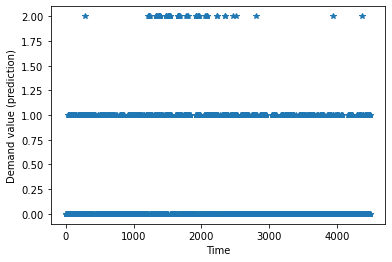

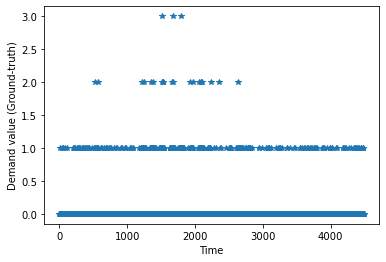

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

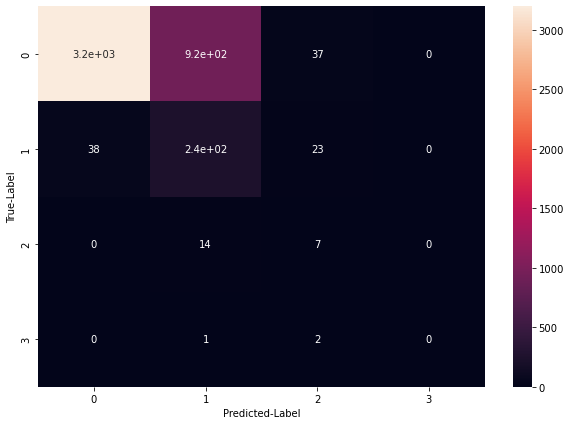

In [65]:

best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.1,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)


 False 

####################################### PREDICTION #################################################


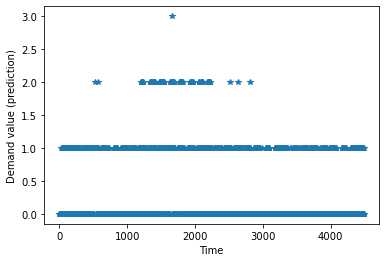

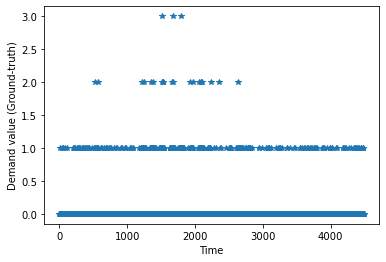

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

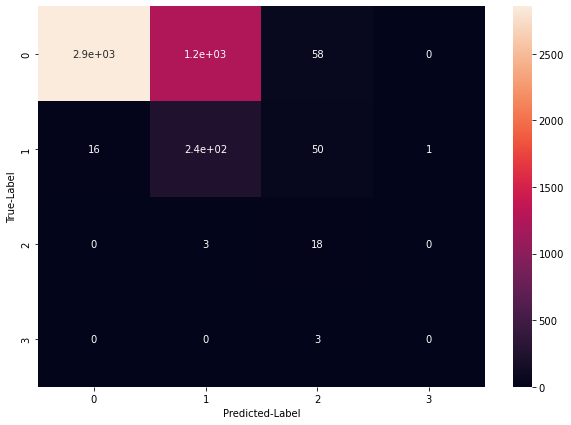

In [59]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.01,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)


 False 

####################################### PREDICTION #################################################


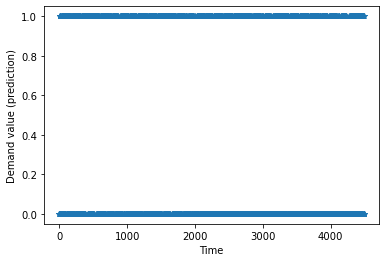

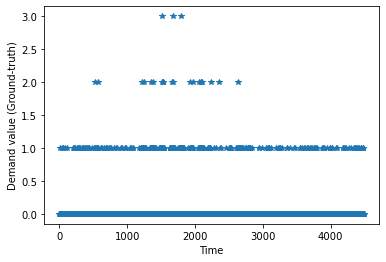

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

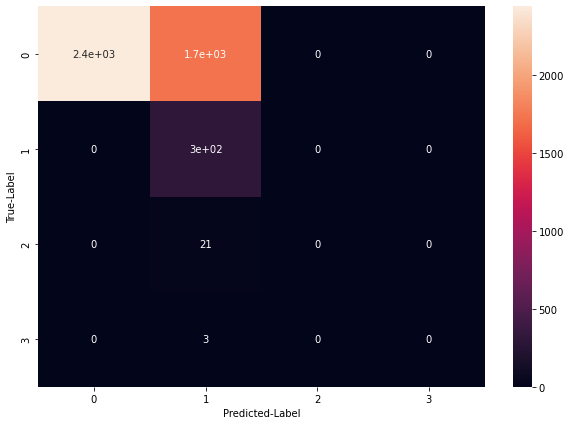

In [60]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)


 False 

####################################### PREDICTION #################################################


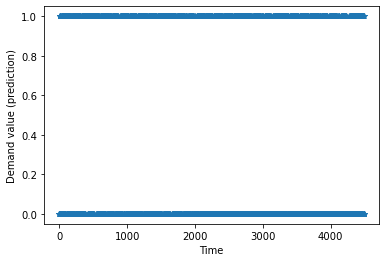

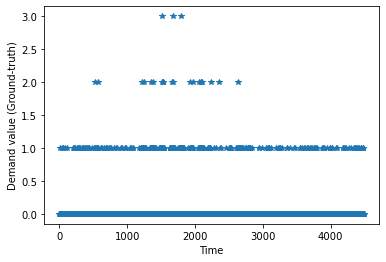

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

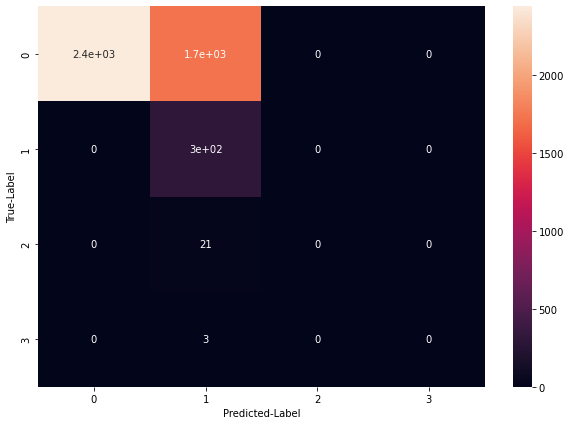

In [61]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.0001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)


 False 

####################################### PREDICTION #################################################


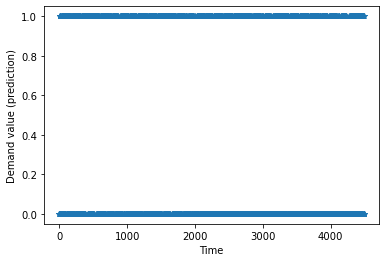

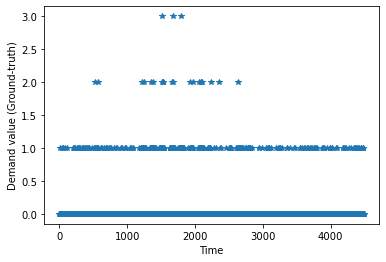

##################################################################################################


(       rem_blk_outf  net_inflow_stn  en_route_inf  net_inflow_clstr_10_min  \
 8928            0.0               1           0.0                      0.0   
 8929            0.0               1           0.0                      0.0   
 8930            0.0               0           0.0                      0.0   
 8931            0.0               0           0.0                      0.0   
 8932            0.0              -1           0.0                      0.0   
 ...             ...             ...           ...                      ...   
 40195           1.0               1           0.0                      1.0   
 40196           0.0               1           1.0                      1.0   
 40197           0.0               2           0.0                      1.0   
 40198           0.0               2           2.0                      1.0   
 40199           0.0               4           0.0                      1.0   
 
        DeepAR_agg_outflow  p_1wk_o  p_2wk_o  p_3w

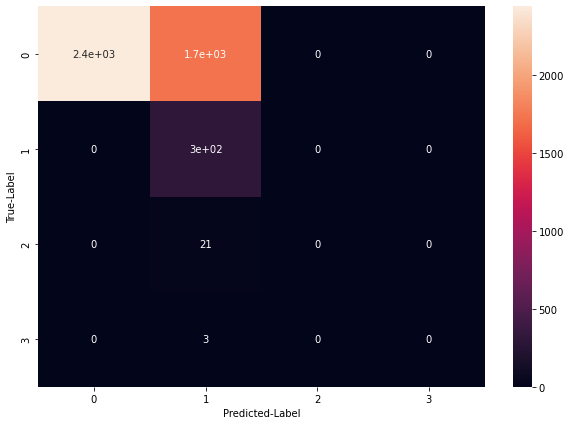

In [62]:
best_tweedie_variance_power = study.best_params["tweedie_variance_power"]
best_params = {"max_depth": study.best_params["max_depth"],
        "eta": 0.00001,
        "subsample" : study.best_params["subsample"],
        "colsample_bytree": study.best_params["colsample_bytree"],
        'eval_metric':'tweedie-nloglik@'+str(best_tweedie_variance_power), ## try using AUC as well.. 
        'tweedie_variance_power': best_tweedie_variance_power,
        'gamma': study.best_params["gamma"],
        'reg_alpha': study.best_params["reg_alpha"], 
        'reg_lambda': study.best_params["reg_lambda"],
        'min_child_weight': study.best_params["min_child_weight"],
        "objective": 'reg:tweedie',
        }
early_stopping_rounds = 30
eval_metric = 'tweedie-nloglik@'+str(best_tweedie_variance_power)
num_round= 1000

t_v_t = train_validate_n_test()
best_model = t_v_t.make_predictions(best_params,num_round, early_stopping_rounds)
t_v_t.evaluate_predictions(best_model)